In [0]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.max_columns=None


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(context='notebook',style='ticks',palette='pastel',font='monospace')

pd.set_option('display.float_format', '{:.7f}'.format)

np.set_printoptions(suppress=True, precision=7)

from scipy.stats import uniform, randint ,loguniform, ks_2samp

from sklearn.model_selection import train_test_split, cross_val_score , KFold , GridSearchCV, RandomizedSearchCV,\
cross_val_predict, StratifiedKFold, cross_validate


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder , OrdinalEncoder, PowerTransformer


from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor, \
HistGradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.utils import resample


from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, \
explained_variance_score

from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from lightgbm import early_stopping

from sklearn.feature_selection import RFE,f_regression,SelectKBest,mutual_info_regression

from sklearn.inspection import permutation_importance


from itertools import combinations
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import shap

In [1]:
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred)) 
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [2]:
def adjusted_r2(r2, n, p):
    """
    Calculate Adjusted R-squared.
    
    Parameters:
    r2: float - Regular R-squared value.
    n: int - Number of observations (samples).
    p: int - Number of predictors (independent variables).

    Returns:
    float - Adjusted R-squared.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [3]:
def model_performance(model, X, y, return_value=False):
    
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    mae =  mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    r2 = r2_score(y,y_pred)
    r2_adj = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    print("Mean Squared Error ",mse)
    print("Root Mean Squared Error ", rmse)
    print("Mean Absolute Error ", mae)
    print("Mean Absolute Percentage Error ",mape)
    print("R2 score ", r2)
    print("Adjusted R2 score ", r2_adj)
    
    if return_value:
           return mse, rmse, mae, mape, r2, r2_adj
    else:
        pass

In [4]:
model_performance_report_df = pd.DataFrame(columns=['Model Name','Mse_train', 'Mse_test', 'Rmse_train', 'Rmse_test', 'Mae_train',
                                                   'Mae_test', 'Mape_train', 'Mape_test', 'R2_train', 'R2_test',
                                                   'R2_adj_train', 'R2_adj_test'])

def model_performance_report(model_name , model, X_train, y_train, X_test, y_test):
    global  model_performance_report_df
    y_pred_train_performance = model_performance(model, X=X_train, y=y_train, return_value=True)
    y_pred_test_performance = model_performance(model, X=X_test, y=y_test, return_value=True)
    
    model_performance_report_df_new = pd.DataFrame({'Model Name': model_name,
                                                    'Mse_train':[y_pred_train_performance[0]] , 
                                                    'Mse_test':[y_pred_test_performance[0]], 
                                                'Rmse_train':[y_pred_train_performance[1]], 
                                                    'Rmse_test':[y_pred_test_performance[1]], 
                                                'Mae_train':[y_pred_train_performance[2]],
                                                    'Mae_test':[y_pred_test_performance[2]], 
                                                    'Mape_train': [y_pred_train_performance[3]], 
                                                    'Mape_test': [y_pred_test_performance[3]], 
                                                'R2_train': [y_pred_train_performance[4]], 
                                                    'R2_test': [y_pred_test_performance[4]],
                                               'R2_adj_train':[y_pred_train_performance[5]] , 
                                                'R2_adj_test': [y_pred_test_performance[5]]})
    
    model_performance_report_df = pd.concat([model_performance_report_df,model_performance_report_df_new], axis=0,ignore_index=True)
    
    return model_performance_report_df


In [5]:
def feature_selection_rfe(model,X,y,num_features=None):
    selector = RFE(estimator=model,n_features_to_select=num_features)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    df_importance = pd.DataFrame({
        'Feature': X.columns,
        'Ranking': selector.ranking_,
        })
    return df_importance.sort_values(by='Ranking', ascending=True)

In [6]:

def get_feature_importance_with_plot(model, feature_names, title="Feature Importance", figsize=(15, 15), get_plot=True, return_df=False):
    """
    Retrieve and display feature importance from a model with a bar plot.
    
    Parameters:
    - model: The trained machine learning model.
    - feature_names: List of feature names corresponding to the input data.
    - title: Title of the bar plot (default is "Feature Importance").
    - figsize: Size of the plot (default is (10, 6)).
    
    Returns:
    - DataFrame containing features and their importance.
    """
    importance = None
    
    if hasattr(model, "feature_importances_"):
        # For tree-based models
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        # For linear models or models with coefficients
        importance = model.coef_
        if isinstance(importance, np.ndarray) and len(importance.shape) > 1:
            importance = importance.ravel()  # Flatten if multidimensional
    else:
        raise ValueError("The provided model does not support feature importance extraction.")
    
    # Create a DataFrame to display importance
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)
    
    # Plot the feature importances
    if get_plot:
        plt.figure(figsize=figsize)
        sns.barplot(
            x="Importance", 
            y="Feature", 
            data=importance_df, 
            palette="viridis"
        )
        plt.title(title, fontsize=25)
        plt.xlabel("Importance", fontsize=25)
        plt.ylabel("Feature", fontsize=25)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()
    
    if return_df:
        return importance_df

In [7]:
# Generate cross-validated predictions
def plot_residual_plot(model, X_train, y_train, n_split=5):
    cv_predictions = cross_val_predict(model, X_train, y_train, cv=n_split)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.scatter(y_train, cv_predictions, alpha=0.6, color="blue")
    plt.plot([min(y_train), max(y_train)],
             [min(y_train), max(y_train)], 
             color='red', linestyle='--', linewidth=1)
    plt.title("Actual vs Predicted (Cross-Validated)")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    residuals = y_train - cv_predictions

    # Plot residuals
    plt.subplot(122)
    plt.scatter(cv_predictions, residuals, alpha=0.6, color="green")
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.title("Residual Plot (Cross-Validated)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.subplots_adjust(wspace=0.3)  # Increase the horizontal space between plots
    plt.tight_layout()  # Ensure everything fits nicely in the figure
    plt.show()

In [8]:
def train_regression_model(X_train, X_test, y_train, y_test, model=None, **params):
    """
    Function to train and evaluate a regression model.

    Parameters:
    X_train (array-like): Features for training.
    X_test (array-like): Features for testing.
    y_train (array-like): Target variable for training.
    y_test (array-like): Target variable for testing.
    model (sklearn regressor, optional): The regression model to train. If None, uses GradientBoostingRegressor.
    **params: Additional parameters to pass to the model.

    Returns:
    dict: Dictionary containing model performance metrics: 'mse', 'r2', 'model'.
    """
    if model is None:
        model = GradientBoostingRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Calculate performance metrics
    print("Training performance: ")
    print(model_performance(model, X_train, y_train))
    print()
    print("Testing performance: ")
    print(model_performance(model ,X_test, y_test))

    # Return performance metrics and the trained model
    return {
        'model': model
    }

In [9]:
def tune_regression_model(X_train, X_test, y_train, y_test, model=None, search_method='grid', param_space=None, n_iter=50,
                         cv=5 , shuffle=True, scoring='r2'):
    """
    Function to perform hyperparameter tuning for a regression model using GridSearchCV, RandomizedSearchCV, or BayesSearchCV.
    
    Parameters:
    - X_train (array-like): Features for training.
    - X_test (array-like): Features for testing.
    - y_train (array-like): Target variable for training.
    - y_test (array-like): Target variable for testing.
    - model (sklearn regressor, optional): The regression model to tune. If None, uses GradientBoostingRegressor.
    - search_method (str): Hyperparameter search method to use ('grid', 'random', 'bayes').
    - param_space (dict): The parameter space or grid for tuning.
    - n_iter (int): Number of iterations for randomized or Bayesian search methods.
    
    Returns:
    - dict: Dictionary containing the best hyperparameters, model performance metrics, and the trained model.
    """
    
    kf = KFold(n_splits=cv, shuffle=shuffle)
    
    if model is None:
        model = GradientBoostingRegressor()

    # Default parameter grids/distributions for GradientBoostingRegressor
    if param_space is None:
        param_space = {
            'learning_rate': [0.01, 0.05, 0.1] if search_method == 'grid' else uniform(0.01, 0.1),
            'n_estimators': [50, 100, 200] if search_method == 'grid' else randint(50, 200),
            'max_depth': [3, 5, 7] if search_method == 'grid' else randint(3, 10),
            'min_samples_split': [2, 5, 10] if search_method == 'grid' else randint(2, 10),
            'min_samples_leaf': [1, 2, 4] if search_method == 'grid' else randint(1, 5),
            'subsample': [0.7, 0.9, 1.0] if search_method == 'grid' else uniform(0.5, 0.5),
            'max_features': ['auto', 'sqrt', 'log2']
        }

    if search_method == 'grid':
        # GridSearchCV for exhaustive search
        search = GridSearchCV(
            model,
            param_space,
            cv=kf,
            n_jobs=-1,
            verbose=2,
            scoring=scoring
        )
    elif search_method == 'random':
        # RandomizedSearchCV for random search
        search = RandomizedSearchCV(
            model,
            param_space,
            n_iter=n_iter,
            cv=kf,
            n_jobs=-1,
            verbose=2,
            scoring=scoring
        )
    elif search_method == 'bayes':
        # BayesSearchCV for Bayesian optimization
        search = BayesSearchCV(
            model,
            param_space,
            n_iter=n_iter,
            cv=kf,
            n_jobs=-1,
            verbose=2,
            scoring=scoring,
            refit=True,
            return_train_score=True
        )
    else:
        raise ValueError("Invalid search_method. Choose from 'grid', 'random', or 'bayes'.")

    # Perform the search
    search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = search.best_estimator_
    best_params = search.best_params_

    # Make predictions
    y_pred_train = best_model.predict(X_train)
    
    y_pred_test = best_model.predict(X_test)

    # Calculate performance metrics
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    
    test_rmse = root_mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Return the results
    return {
        'best_params': best_params,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
         'train_r2': train_r2,
        'test_r2': test_r2,
        'model': best_model
    }

In [10]:
def plot_learning_curve(model, X_train, y_train, X_test, y_test):
    # Extract staged predictions for training and testing
    train_errors = []
    test_errors = []
    
    model = model
    model.fit(X_train, y_train)
    
    
    for y_pred_train, y_pred_test in zip(
        model.staged_predict(X_train), model.staged_predict(X_test)
    ):
        train_errors.append(mean_squared_error(y_train, y_pred_train))
        test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    # Convert to numpy arrays for plotting
    train_errors = np.array(train_errors)
    test_errors = np.array(test_errors)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(np.sqrt(train_errors), label="Training RMSE", marker='o')
    plt.plot(np.sqrt(test_errors), label="Testing RMSE", marker='o')
    plt.axvline(np.argmin(test_errors), color='r', linestyle='--', label="Optimal Iteration")
    plt.xlabel("Number of Trees")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Optimal Iteration: {np.argmin(test_errors)}")

In [11]:
def plot_model_rmse(model, X_train, X_test, y_train, y_test, num_boost_round=100):
    """
    Trains the provided LGBMRegressor model and plots the training and testing RMSE against epochs,
    using pre-split training and testing data.

    Parameters:
        model (LGBMRegressor): A LightGBM Regressor model instance with parameters already set.
        X_train (pd.DataFrame or np.ndarray): Training feature matrix.
        X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
        y_train (pd.Series or np.ndarray): Training target vector.
        y_test (pd.Series or np.ndarray): Testing target vector.
        num_boost_round (int): Number of boosting rounds (epochs).

    Returns:
        None
    """
    # Initialize a dictionary to store RMSE values
    rmse_scores = {"train": [], "test": []}

    # Custom callback to calculate RMSE at each iteration
    def rmse_callback(env):
        # Predict on training and testing data
        train_pred = env.model.predict(X_train, num_iteration=env.iteration)
        test_pred = env.model.predict(X_test, num_iteration=env.iteration)
        
        # Calculate RMSE for training and testing sets
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        # Store RMSE values
        rmse_scores["train"].append(train_rmse)
        rmse_scores["test"].append(test_rmse)

    # Use the `fit` method to train the model with early stopping and custom callback
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric="l2",  # RMSE is related to l2 (mean squared error)
        callbacks=[rmse_callback]
    )

    # Extract RMSE values
    train_rmse = rmse_scores["train"]
    test_rmse = rmse_scores["test"]
    epochs = range(1, len(train_rmse) + 1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_rmse, label="Train RMSE", marker='o')
    plt.plot(epochs, test_rmse, label="Test RMSE", marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.title("Train and Test RMSE vs Epochs")
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
def plot_model_r2(model, X_train, X_test, y_train, y_test, num_boost_round=100):
    """
    Trains the provided LGBMRegressor model and plots the training and testing R² against epochs,
    using pre-split training and testing data.

    Parameters:
        model (LGBMRegressor): A LightGBM Regressor model instance with parameters already set.
        X_train (pd.DataFrame or np.ndarray): Training feature matrix.
        X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
        y_train (pd.Series or np.ndarray): Training target vector.
        y_test (pd.Series or np.ndarray): Testing target vector.
        num_boost_round (int): Number of boosting rounds (epochs).

    Returns:
        None
    """
    # Initialize a dictionary to store R² values
    r2_scores = {"train": [], "test": []}

    # Custom callback to calculate R² at each iteration
    def r2_callback(env):
        # Predict on training and testing data
        train_pred = env.model.predict(X_train, num_iteration=env.iteration)
        test_pred = env.model.predict(X_test, num_iteration=env.iteration)
        
        # Calculate R² for training and testing sets
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        # Store R² values
        r2_scores["train"].append(train_r2)
        r2_scores["test"].append(test_r2)

    # Use the `fit` method to train the model with early stopping and custom callback
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric="l2",  # R² is indirectly related to the l2 (mean squared error)
        callbacks=[r2_callback]
    )

    # Extract R² values
    train_r2 = r2_scores["train"]
    test_r2 = r2_scores["test"]
    epochs = range(1, len(train_r2) + 1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2, label="Train R²", marker='o')
    plt.plot(epochs, test_r2, label="Test R²", marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("R² Score")
    plt.title("Train and Test R² vs Epochs")
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
# Reading csv file
auto_insurance_df = pd.read_csv('Dataset/AutoInsurance.csv')
auto_insurance_df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.5192790,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.8111470,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.5359030,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.4649350,Four-Door Car,Medsize
2,AI49188,Nevada,12887.4316500,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.4722470,Two-Door Car,Medsize
3,WW63253,California,7645.8618270,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.8813440,SUV,Medsize
4,HB64268,Washington,2813.6925750,No,Basic,Bachelor,3/2/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.1308790,Four-Door Car,Medsize


In [14]:
# we have 9134 rows and 24 columns

In [15]:
auto_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [16]:
auto_insurance_df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.0000000,9134.0000000,9134.0000000,9134.0000000,9134.0000000,9134.0000000,9134.0000000,9134.0000000
mean,8004.9404750,37657.3800088,93.2192906,15.0970002,48.0645938,0.3843880,2.9661704,434.0887943
std,6870.9676084,30379.9047338,34.4079674,10.0732566,27.9059908,0.9103835,2.3901818,290.5000918
min,1898.0076750,0.0000000,61.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.0990070
25%,3994.2517942,0.0000000,68.0000000,6.0000000,24.0000000,0.0000000,1.0000000,272.2582445
50%,5780.1821970,33889.5000000,83.0000000,14.0000000,48.0000000,0.0000000,2.0000000,383.9454335
75%,8962.1670413,62320.0000000,109.0000000,23.0000000,71.0000000,0.0000000,4.0000000,547.5148387
max,83325.3811900,99981.0000000,298.0000000,35.0000000,99.0000000,5.0000000,9.0000000,2893.2396780


# Data Preprocessing

In [17]:
auto_insurance_df_copy = auto_insurance_df.copy()

In [18]:
auto_insurance_df_copy['Policy'].value_counts()

Policy
Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: count, dtype: int64

In [19]:
auto_insurance_df_copy['Policy'] = auto_insurance_df_copy['Policy'].apply(lambda x:x[-2:])

In [20]:
auto_insurance_df_copy['Policy'].value_counts()

Policy
L3    4588
L2    2881
L1    1665
Name: count, dtype: int64

In [21]:

or_coverage = OrdinalEncoder(categories=[['Basic', 'Extended', 'Premium']])
# change the encoding by order basic -> 0, Extended -> 1 and Premium -> 2
auto_insurance_df_copy['Coverage'] = or_coverage.fit_transform(auto_insurance_df['Coverage'].values.reshape(-1,1)).astype('int8') 


#or_edu = OrdinalEncoder(categories=[['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']])
# change the encoding by order High School or Below -> 0, College -> 1, Bachelor -> 2, Master -> 3 and Doctor -> 4
#X_train['Education'] = or_edu.fit_transform(X_train['Education'].values.reshape(-1,1)).astype('int8')  
#X_test['Education'] = or_edu.transform(X_test['Education'].values.reshape(-1,1)).astype('int8')  


# changing All the records having Education as Master and Doctor into Master and Above
auto_insurance_df_copy['Education'].replace(to_replace=['Master','Doctor'],value='Master and Above', inplace=True)

or_edu = OrdinalEncoder(categories=[['High School or Below', 'College', 'Bachelor', 'Master and Above']])

auto_insurance_df_copy['Education'] = or_edu.fit_transform(auto_insurance_df_copy['Education'].values.reshape(-1,1)).astype('int8') 



or_Marital_Stat = OrdinalEncoder(categories=[['Married', 'Single', 'Divorced']])
# change the encoding by order Single -> 0, Married -> 1 and Divorced -> 2
auto_insurance_df_copy['Marital Status'] = or_Marital_Stat.fit_transform(auto_insurance_df_copy['Marital Status'].values.reshape(-1,1)).astype('int8')  

or_vec_class = OrdinalEncoder(categories=[['Two-Door Car', 'Four-Door Car', 'SUV', 'Sports Car', 'Luxury Car', 'Luxury SUV']])
# 'Two-Door Car' -> 0 , 'Four-Door Car'-> 1 , 'SUV' -> 2 , 'Sports Car' -> 3, 'Luxury Car' -> 4, 'Luxury SUV' -> 5
auto_insurance_df_copy['Vehicle Class'] = or_vec_class.fit_transform(auto_insurance_df_copy['Vehicle Class'].values.reshape(-1,1)).astype('int8')  

or_policy = OrdinalEncoder(categories=[['L1', 'L2', 'L3']])
# L1 -> 0 , L2-> 1 ,and L3 -> 2 
auto_insurance_df_copy['Policy'] = or_policy.fit_transform(auto_insurance_df_copy['Policy'].values.reshape(-1,1)).astype('int8')

or_vec_size = OrdinalEncoder(categories=[['Small', 'Medsize', 'Large']])
# Small -> 0 , 'Medsize'-> 1 ,and 'Large' -> 2 
auto_insurance_df_copy['Vehicle Size'] = or_vec_size.fit_transform(auto_insurance_df_copy['Vehicle Size'].values.reshape(-1,1)).astype('int8')   

In [22]:
#auto_insurance_df_copy['Effective To Date'] = pd.to_datetime(auto_insurance_df_copy['Effective To Date'])

# Assuming the current date for calculations
#date = pd.to_datetime("2011-12-31")

# 1. Time-Based Features
#auto_insurance_df_copy['Days_Since_Policy_Inception'] = (reference_date - auto_insurance_df_copy['Effective To Date']).dt.days
#auto_insurance_df_copy['Days_Since_Last_Claim'] = auto_insurance_df_copy['Months Since Last Claim'] * 30  # Approximation

auto_insurance_df_copy['Region'] = auto_insurance_df_copy['State'].apply(lambda x: 'West' if x in ['California', 'Oregon', 'Nevada'] else 'East')  # Example grouping

#auto_insurance_df_copy['Claim_Efficiency'] = auto_insurance_df_copy['Total Claim Amount'] / (auto_insurance_df_copy['Monthly Premium Auto'] + 1e-6)
#auto_insurance_df_copy['Policy_Stability'] = auto_insurance_df_copy['Number of Policies'] / (auto_insurance_df_copy['Number of Open Complaints'] + 1e-6)




auto_insurance_df_copy.drop(['Effective To Date','Customer','State'], axis=1, inplace=True)
#droping the 'Effective To Date as it is not important for our model
# dropping Customer column as it is not important for our model


auto_insurance_df_copy.rename(columns={'Customer Lifetime Value':'CLV'},inplace=True)



auto_insurance_df_copy['EmploymentStatus'].replace(to_replace=['Medical Leave','Disabled','Retired'],
                                                   value='Other', inplace=True)
auto_insurance_df_copy.head()

,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Region
0,2763.5192790,No,0,2,Employed,F,56274,Suburban,0,69,32,5,0,1,Corporate Auto,2,Offer1,Agent,384.8111470,0,1,East
1,6979.5359030,No,1,2,Unemployed,F,0,Suburban,1,94,13,42,0,8,Personal Auto,2,Offer3,Agent,1131.4649350,1,1,East
2,12887.4316500,No,2,2,Employed,F,48767,Suburban,0,108,18,38,0,2,Personal Auto,2,Offer1,Agent,566.4722470,0,1,West
3,7645.8618270,No,0,2,Unemployed,M,0,Suburban,0,106,18,65,0,7,Corporate Auto,1,Offer1,Call Center,529.8813440,2,1,West
4,2813.6925750,No,0,2,Employed,M,43836,Rural,1,73,12,44,0,1,Personal Auto,0,Offer1,Agent,138.1308790,1,1,East


In [23]:
auto_insurance_df_copy.memory_usage()

Index                              132
CLV                              73072
Response                         73072
Coverage                          9134
Education                         9134
EmploymentStatus                 73072
Gender                           73072
Income                           73072
Location Code                    73072
Marital Status                    9134
Monthly Premium Auto             73072
Months Since Last Claim          73072
Months Since Policy Inception    73072
Number of Open Complaints        73072
Number of Policies               73072
Policy Type                      73072
Policy                            9134
Renew Offer Type                 73072
Sales Channel                    73072
Total Claim Amount               73072
Vehicle Class                     9134
Vehicle Size                      9134
Region                           73072
dtype: int64

In [24]:
int_cols = auto_insurance_df_copy.select_dtypes(include=['int64']).columns.tolist()
int_cols.remove('Income')
int_cols.remove('Monthly Premium Auto')

auto_insurance_df_copy[int_cols] = auto_insurance_df_copy[int_cols].astype('int8')
auto_insurance_df_copy.head()

,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Region
0,2763.5192790,No,0,2,Employed,F,56274,Suburban,0,69,32,5,0,1,Corporate Auto,2,Offer1,Agent,384.8111470,0,1,East
1,6979.5359030,No,1,2,Unemployed,F,0,Suburban,1,94,13,42,0,8,Personal Auto,2,Offer3,Agent,1131.4649350,1,1,East
2,12887.4316500,No,2,2,Employed,F,48767,Suburban,0,108,18,38,0,2,Personal Auto,2,Offer1,Agent,566.4722470,0,1,West
3,7645.8618270,No,0,2,Unemployed,M,0,Suburban,0,106,18,65,0,7,Corporate Auto,1,Offer1,Call Center,529.8813440,2,1,West
4,2813.6925750,No,0,2,Employed,M,43836,Rural,1,73,12,44,0,1,Personal Auto,0,Offer1,Agent,138.1308790,1,1,East


In [25]:
auto_insurance_df_copy[['CLV','Total Claim Amount']] = auto_insurance_df_copy[['CLV','Total Claim Amount']].astype('float32')

auto_insurance_df_copy[['Income','Monthly Premium Auto']] = auto_insurance_df_copy[['Income','Monthly Premium Auto']].astype('int32')

In [26]:
#auto_insurance_df_copy[['Claim_Efficiency','Policy_Stability']] = auto_insurance_df_copy[['Claim_Efficiency','Policy_Stability']].astype('float32')


In [27]:
auto_insurance_df_copy_cat = auto_insurance_df_copy.select_dtypes('O')
# selecting all the categorical column

cat_columns = auto_insurance_df_copy_cat.columns.tolist()

auto_insurance_df_copy_cat = pd.get_dummies(auto_insurance_df_copy_cat, drop_first=True).astype('int8')
#converting all the categorical into numerical column using one-hot ending

auto_insurance_df_copy_new = pd.concat([auto_insurance_df_copy,auto_insurance_df_copy_cat],axis=1).drop(cat_columns,
                                                                                                        axis=1)
auto_insurance_df_copy_new.columns =  auto_insurance_df_copy_new.columns.str.strip().str.replace(' ','_')

#auto_insurance_df_copy_new.drop('CLV', axis=1, inplace=True)
auto_insurance_df_copy_new.head()

,CLV,Coverage,Education,Income,Marital_Status,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy,Total_Claim_Amount,Vehicle_Class,Vehicle_Size,Response_Yes,EmploymentStatus_Other,EmploymentStatus_Unemployed,Gender_M,Location_Code_Suburban,Location_Code_Urban,Policy_Type_Personal_Auto,Policy_Type_Special_Auto,Renew_Offer_Type_Offer2,Renew_Offer_Type_Offer3,Renew_Offer_Type_Offer4,Sales_Channel_Branch,Sales_Channel_Call_Center,Sales_Channel_Web,Region_West
0,2763.5192871,0,2,56274,0,69,32,5,0,1,2,384.8111572,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,6979.5361328,1,2,0,1,94,13,42,0,8,2,1131.4649658,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0
2,12887.4316406,2,2,48767,0,108,18,38,0,2,2,566.4722290,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
3,7645.8618164,0,2,0,0,106,18,65,0,7,1,529.8813477,2,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1
4,2813.6926270,0,2,43836,1,73,12,44,0,1,0,138.1308746,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [28]:
auto_insurance_df_copy_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CLV                            9134 non-null   float32
 1   Coverage                       9134 non-null   int8   
 2   Education                      9134 non-null   int8   
 3   Income                         9134 non-null   int32  
 4   Marital_Status                 9134 non-null   int8   
 5   Monthly_Premium_Auto           9134 non-null   int32  
 6   Months_Since_Last_Claim        9134 non-null   int8   
 7   Months_Since_Policy_Inception  9134 non-null   int8   
 8   Number_of_Open_Complaints      9134 non-null   int8   
 9   Number_of_Policies             9134 non-null   int8   
 10  Policy                         9134 non-null   int8   
 11  Total_Claim_Amount             9134 non-null   float32
 12  Vehicle_Class                  9134 non-null   i

In [29]:
auto_insurance_df_copy_new.memory_usage()

Index                              132
CLV                              36536
Coverage                          9134
Education                         9134
Income                           36536
Marital_Status                    9134
Monthly_Premium_Auto             36536
Months_Since_Last_Claim           9134
Months_Since_Policy_Inception     9134
Number_of_Open_Complaints         9134
Number_of_Policies                9134
Policy                            9134
Total_Claim_Amount               36536
Vehicle_Class                     9134
Vehicle_Size                      9134
Response_Yes                      9134
EmploymentStatus_Other            9134
EmploymentStatus_Unemployed       9134
Gender_M                          9134
Location_Code_Suburban            9134
Location_Code_Urban               9134
Policy_Type_Personal_Auto         9134
Policy_Type_Special_Auto          9134
Renew_Offer_Type_Offer2           9134
Renew_Offer_Type_Offer3           9134
Renew_Offer_Type_Offer4  

In [30]:
# we able to reduce some memory usage

In [31]:
auto_insurance_df_copy_new.shape

(9134, 29)

In [32]:
# Now we have 9314 and 48 columns

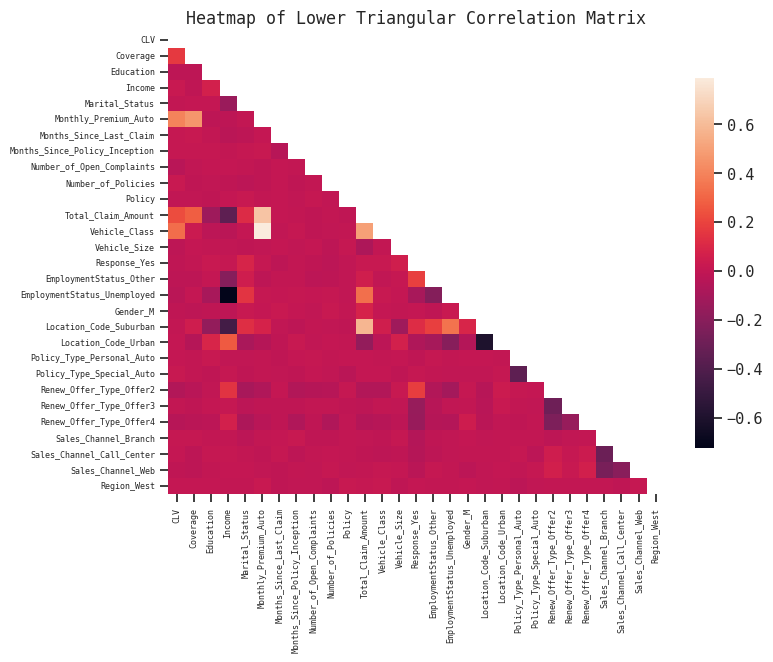

In [33]:
corr_matrix = auto_insurance_df_copy_new.corr()

# Step 3: Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Step 4: Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, mask=mask, fmt=".2f", cbar_kws={'shrink': 0.8})
plt.title('Heatmap of Lower Triangular Correlation Matrix')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

In [34]:
# there is some multicolinearity is present

In [35]:
auto_insurance_df_copy_new.std()

CLV                              6870.9658203
Coverage                            0.6558173
Education                           0.9996642
Income                          30379.9047338
Marital_Status                      0.7382005
Monthly_Premium_Auto               34.4079674
Months_Since_Last_Claim            10.0732566
Months_Since_Policy_Inception      27.9059908
Number_of_Open_Complaints           0.9103835
Number_of_Policies                  2.3901818
Policy                              0.7630468
Total_Claim_Amount                290.4990540
Vehicle_Class                       1.0222965
Vehicle_Size                        0.5373128
Response_Yes                        0.3502971
EmploymentStatus_Other              0.3278911
EmploymentStatus_Unemployed         0.4351334
Gender_M                            0.4999281
Location_Code_Suburban              0.4820981
Location_Code_Urban                 0.3784400
Policy_Type_Personal_Auto           0.4369157
Policy_Type_Special_Auto          

In [36]:
# Income, CLV,Total Claim Amount  have high standard deviation

In [37]:
auto_insurance_df_copy_new.skew()

CLV                              3.0322802
Coverage                         1.0313101
Education                        0.1945943
Income                           0.2868873
Marital_Status                   0.8767589
Monthly_Premium_Auto             2.1235464
Months_Since_Last_Claim          0.2785863
Months_Since_Policy_Inception    0.0401650
Number_of_Open_Complaints        2.7832631
Number_of_Policies               1.2533327
Policy                          -0.6116925
Total_Claim_Amount               1.7149657
Vehicle_Class                    1.3586988
Vehicle_Size                    -0.0727417
Response_Yes                     2.0375670
EmploymentStatus_Other           2.3030416
EmploymentStatus_Unemployed      1.1324634
Gender_M                         0.0398656
Location_Code_Suburban          -0.5505938
Location_Code_Urban              1.7274736
Policy_Type_Personal_Auto       -1.1133071
Policy_Type_Special_Auto         4.6058831
Renew_Offer_Type_Offer2          0.7701883
Renew_Offer

In [38]:
# Policy_Special L1,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV is most skewed columns

In [39]:
auto_insurance_df_copy_new['Monthly_Premium_Auto'].describe()

count   9134.0000000
mean      93.2192906
std       34.4079674
min       61.0000000
25%       68.0000000
50%       83.0000000
75%      109.0000000
max      298.0000000
Name: Monthly_Premium_Auto, dtype: float64

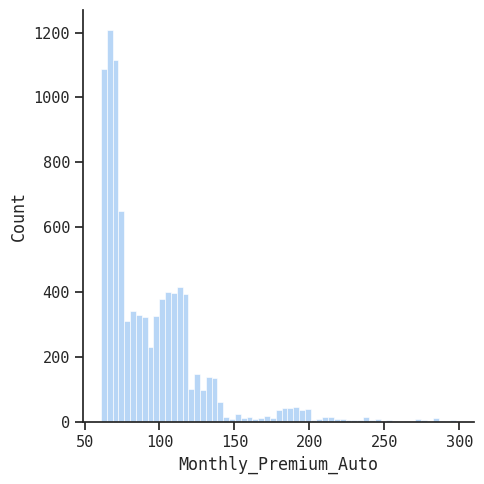

In [40]:
sns.displot(auto_insurance_df_copy_new['Monthly_Premium_Auto'])
plt.show()

In [41]:
auto_insurance_df_copy_new['Monthly_Premium_Auto'].skew()

2.1235464499475345

In [42]:
#np.power(auto_insurance_df_copy_new['Monthly_Premium_Auto'],1/100).skew()

In [43]:
pow_trans = PowerTransformer(method='box-cox')

auto_insurance_df_copy_new['Monthly_Premium_Auto'] = pow_trans.fit_transform(auto_insurance_df_copy_new['Monthly_Premium_Auto'].values.reshape(-1,1))

In [44]:
auto_insurance_df_copy_new['Monthly_Premium_Auto'].skew()

0.17458906013251846

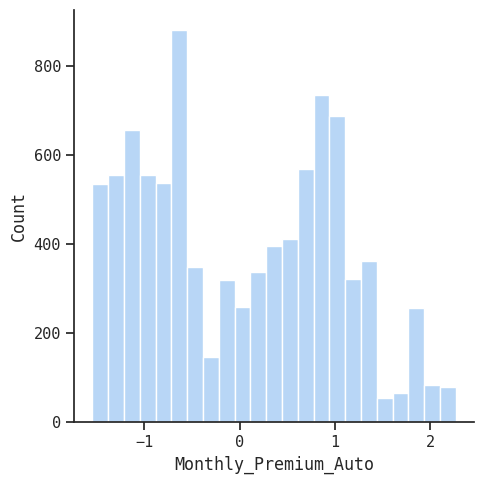

In [45]:
sns.displot(auto_insurance_df_copy_new['Monthly_Premium_Auto'])
plt.show()

In [46]:
auto_insurance_df_copy_new['Monthly_Premium_Auto'].describe()

count   9134.0000000
mean      -0.0000000
std        1.0000547
min       -1.5468727
25%       -0.9267207
50%       -0.0151072
75%        0.8715318
max        2.2710973
Name: Monthly_Premium_Auto, dtype: float64

In [47]:
#auto_insurance_df_copy_new['Number_of_Open_Complaints'] = pd.Series(np.where(auto_insurance_df_copy_new['Number_of_Open_Complaints']==0,0,1/auto_insurance_df_copy_new['Number_of_Open_Complaints']))

#auto_insurance_df_copy_new['Number_of_Open_Complaints'].describe()

In [48]:
#auto_insurance_df_copy_new['Number_of_Open_Complaints'] = np.power(auto_insurance_df_copy_new['Number_of_Open_Complaints'],1/10)

In [49]:
auto_insurance_df_copy_new['Total_Claim_Amount'].skew()

1.7149657

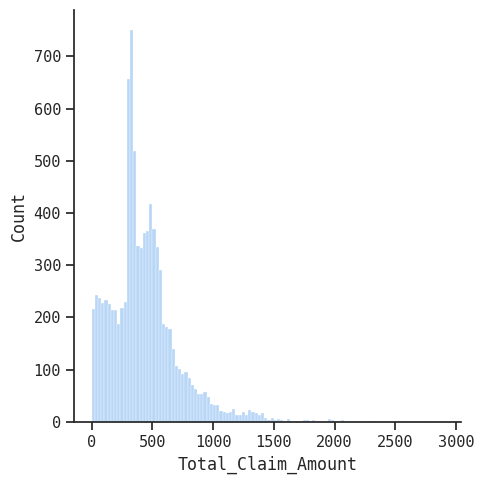

In [50]:
sns.displot(auto_insurance_df_copy_new['Total_Claim_Amount'])
plt.show()

In [51]:
pow_transform = PowerTransformer(method='yeo-johnson', standardize=True)
auto_insurance_df_copy_new['Total_Claim_Amount'] = pd.Series(pow_transform.fit_transform(auto_insurance_df_copy_new['Total_Claim_Amount'].values.reshape(-1, 1)).reshape(auto_insurance_df_copy_new['Number_of_Open_Complaints'].shape[0],))

In [52]:
auto_insurance_df_copy_new['Total_Claim_Amount'].skew()

0.04667292

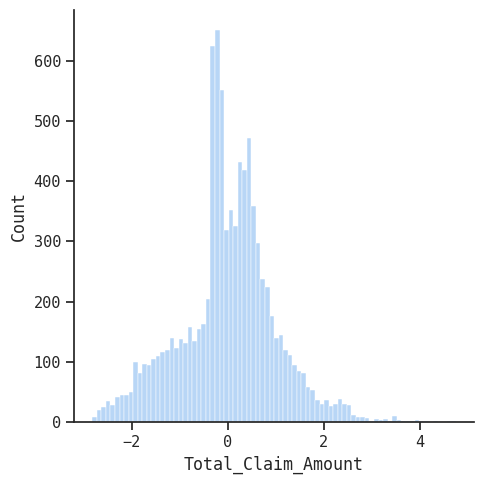

In [53]:
sns.displot(auto_insurance_df_copy_new['Total_Claim_Amount'])
plt.show()

In [54]:
auto_insurance_df_copy_new.skew()

CLV                              3.0322802
Coverage                         1.0313101
Education                        0.1945943
Income                           0.2868873
Marital_Status                   0.8767589
Monthly_Premium_Auto             0.1745891
Months_Since_Last_Claim          0.2785863
Months_Since_Policy_Inception    0.0401650
Number_of_Open_Complaints        2.7832631
Number_of_Policies               1.2533327
Policy                          -0.6116925
Total_Claim_Amount               0.0466729
Vehicle_Class                    1.3586988
Vehicle_Size                    -0.0727417
Response_Yes                     2.0375670
EmploymentStatus_Other           2.3030416
EmploymentStatus_Unemployed      1.1324634
Gender_M                         0.0398656
Location_Code_Suburban          -0.5505938
Location_Code_Urban              1.7274736
Policy_Type_Personal_Auto       -1.1133071
Policy_Type_Special_Auto         4.6058831
Renew_Offer_Type_Offer2          0.7701883
Renew_Offer

# Data Splitting

In [55]:
X = auto_insurance_df_copy_new.drop(['CLV'], axis=1)

y = auto_insurance_df_copy_new['CLV']

In [56]:
# Spliting the X and y data but out target is skew

In [57]:
# Create bins for the target variable
num_bins = 10  # Adjust the number of bins as needed
bins = pd.qcut(y, q=num_bins, duplicates='drop')

# Perform stratified splitting based on the bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=bins, random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train.skew())
print(y_test.skew())

(7307, 28)
(1827, 28)
(7307,)
(1827,)
3.0663123
2.9044552


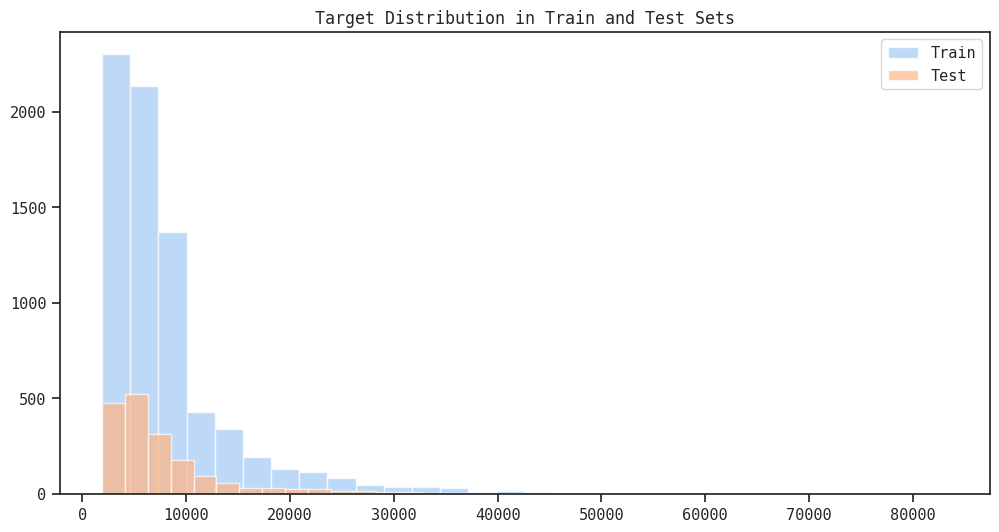

In [58]:
plt.figure(figsize=(12, 6))
plt.hist(y_train, bins=30, alpha=0.7, label="Train")
plt.hist(y_test, bins=30, alpha=0.7, label="Test")
plt.legend()
plt.title("Target Distribution in Train and Test Sets")
plt.show()

In [59]:
stat, p_value = ks_2samp(y_train, y_test)
print(f"KS Statistic: {stat}, P-Value: {p_value}")
if p_value > 0.05:
    print("Train and test distributions are statistically similar.")
else:
    print("Distributions differ significantly.")

KS Statistic: 0.014168732039644675, P-Value: 0.9259405165820087
Train and test distributions are statistically similar.


In [60]:
#We can see the train and test are very similar

In [61]:
# {'yeo-johnson', 'box-cox'}
#pow_transform = PowerTransformer(method='box-cox', standardize=True)
#y_train_transformed = pd.Series(pow_transform.fit_transform(y_train.values.reshape(-1, 1)).reshape(y_train.shape[0],))
#scaler = RobustScaler()

y_train_transformed = pd.Series(np.where(y_train==0,0,1/y_train))

#scaler.fit_transform(y_train.values.reshape(1,-1))
#y_test_transformed = pd.Series(pow_transform.fit_transform(y_test.values.reshape(-1,1)).reshape(y_test.shape[0],))

y_test_transformed = pd.Series(np.where(y_test==0,0,1/y_test))
#scaler.transform(y_test.values.reshape(1,-1))

print(y_train_transformed.skew())
print(y_test_transformed.skew())

0.6976135
0.68760735


# Model training and optimization

In [62]:
X_train.head()

,Coverage,Education,Income,Marital_Status,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy,Total_Claim_Amount,Vehicle_Class,Vehicle_Size,Response_Yes,EmploymentStatus_Other,EmploymentStatus_Unemployed,Gender_M,Location_Code_Suburban,Location_Code_Urban,Policy_Type_Personal_Auto,Policy_Type_Special_Auto,Renew_Offer_Type_Offer2,Renew_Offer_Type_Offer3,Renew_Offer_Type_Offer4,Sales_Channel_Branch,Sales_Channel_Call_Center,Sales_Channel_Web,Region_West
6804,1,2,0,0,0.1642045,13,76,0,2,2,0.1240508,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1
488,0,0,23105,0,-0.8506105,15,21,0,3,2,-0.1981192,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1
1734,0,1,29431,0,0.7150914,29,35,0,2,1,-0.6012626,2,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
3452,0,1,0,1,-1.2606780,14,91,0,2,2,0.1177323,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1
5195,1,0,0,1,1.9663241,14,63,0,4,0,2.6508896,4,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1


In [63]:
%%time

rf = train_regression_model(X_train, X_test,y_train_transformed, y_test_transformed, model=RandomForestRegressor())['model']

Training performance: 
Mean Squared Error  3.133479157607907e-11
Root Mean Squared Error  5.597748795371142e-06
Mean Absolute Error  3.0680036839717526e-06
Mean Absolute Percentage Error  0.03828717135014155
R2 score  0.9974196860887304
Adjusted R2 score  0.9974097590772554
None

Testing performance: 
Mean Squared Error  2.0501420580119565e-10
Root Mean Squared Error  1.4318317142778884e-05
Mean Absolute Error  7.897642827071788e-06
Mean Absolute Percentage Error  0.10027577012995173
R2 score  0.9831274828695115
Adjusted R2 score  0.9828647295437863
None
CPU times: total: 4.5 s
Wall time: 4.55 s


In [64]:
%%time

rf = train_regression_model(X_train, X_test,y_train_transformed, y_test_transformed, model=RandomForestRegressor())['model']

Training performance: 
Mean Squared Error  3.0688619926849056e-11
Root Mean Squared Error  5.539731033800202e-06
Mean Absolute Error  3.043150813303069e-06
Mean Absolute Percentage Error  0.037963064345697434
R2 score  0.9974728961345521
Adjusted R2 score  0.9974631738333386
None

Testing performance: 
Mean Squared Error  2.0493225702919137e-10
Root Mean Squared Error  1.4315455180649736e-05
Mean Absolute Error  7.881256461712198e-06
Mean Absolute Percentage Error  0.10004612531625345
R2 score  0.9831342271926868
Adjusted R2 score  0.9828715788953538
None
CPU times: total: 4.44 s
Wall time: 4.48 s


In [65]:
%%time

rf = train_regression_model(X_train, X_test,y_train_transformed, y_test_transformed, model=RandomForestRegressor())['model']

Training performance: 
Mean Squared Error  3.06305536074639e-11
Root Mean Squared Error  5.534487655371896e-06
Mean Absolute Error  3.0433652651231874e-06
Mean Absolute Percentage Error  0.03797755458848006
R2 score  0.9974776776992011
Adjusted R2 score  0.9974679737936746
None

Testing performance: 
Mean Squared Error  2.0166603208200805e-10
Root Mean Squared Error  1.4200916593023425e-05
Mean Absolute Error  7.866022116424554e-06
Mean Absolute Percentage Error  0.09933742169793487
R2 score  0.9834030350841109
Adjusted R2 score  0.9831445728940971
None
CPU times: total: 4.55 s
Wall time: 4.54 s


In [66]:
# Model is getting overfitted slightly

In [67]:
#%%time
#feature_selection_rfe(rf,X=X_train,y=y_train_transformed,num_features=None)

In [68]:
get_feature_importance_with_plot(model=rf, feature_names=X_train.columns, get_plot=False,
    return_df=True)

,Feature,Importance
8,Number_of_Policies,0.6925965
4,Monthly_Premium_Auto,0.2762560
2,Income,0.0102561
7,Number_of_Open_Complaints,0.0027943
6,Months_Since_Policy_Inception,0.0027572
10,Total_Claim_Amount,0.0026809
5,Months_Since_Last_Claim,0.0022392
15,EmploymentStatus_Unemployed,0.0014906
3,Marital_Status,0.0013194
0,Coverage,0.0011393


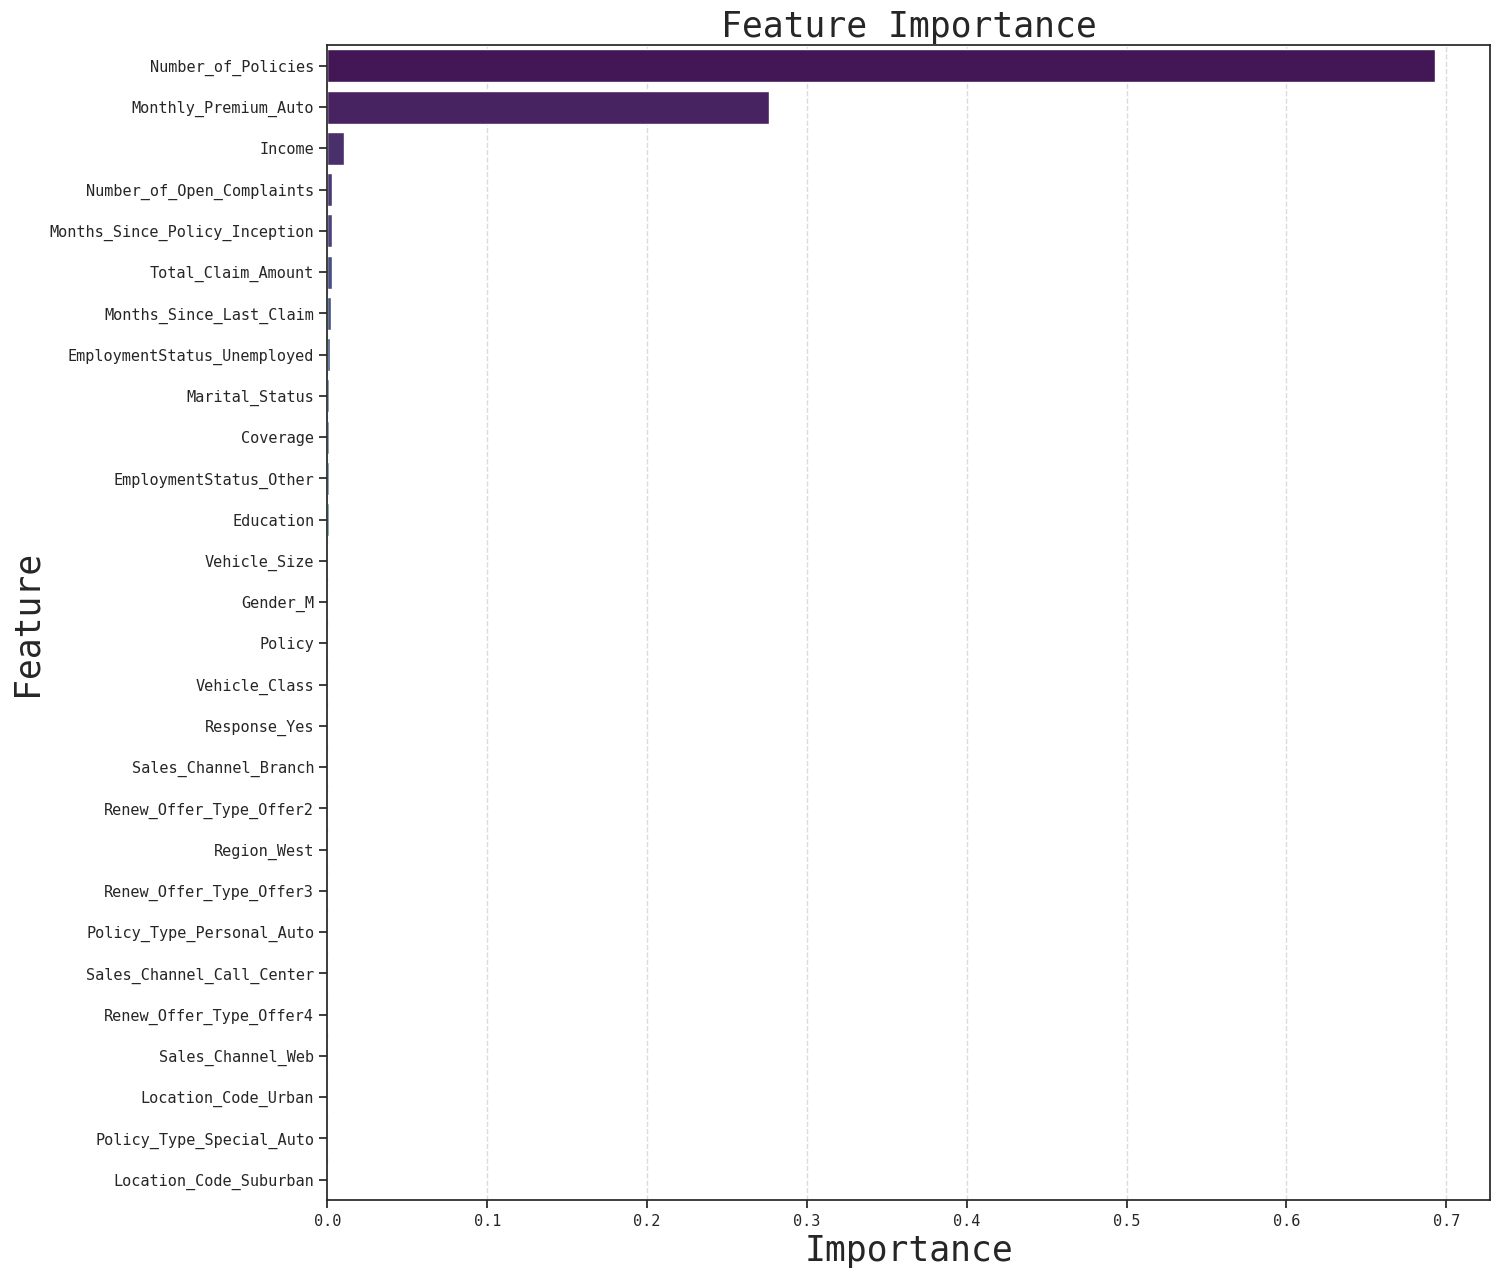

In [69]:
get_feature_importance_with_plot(model=rf, feature_names=X_train.columns, get_plot=True,
    return_df=False)

In [70]:
feat_importance_rf_df  = get_feature_importance_with_plot(model=rf, feature_names=X_train.columns, get_plot=False,
    return_df=True)

cumulative_importance = feat_importance_rf_df["Importance"].cumsum()
threshold = 0.995  # 95%

# Features to keep
selected_features = feat_importance_rf_df[cumulative_importance <= threshold]["Feature"]
print(selected_features)

8                Number_of_Policies
4              Monthly_Premium_Auto
2                            Income
7         Number_of_Open_Complaints
6     Months_Since_Policy_Inception
10               Total_Claim_Amount
5           Months_Since_Last_Claim
15      EmploymentStatus_Unemployed
3                    Marital_Status
0                          Coverage
14           EmploymentStatus_Other
Name: Feature, dtype: object


In [71]:
# Per feature importance Number of Policies and Monthly Premium Auto are most important features.
# Let try some more feature engineering technique and see we able to improve the performance of model

In [72]:
X_train['Yearly_premium'] = X_train['Monthly_Premium_Auto'] * 12
X_test['Yearly_premium'] = X_test['Monthly_Premium_Auto'] * 12

#X_train['Net_revenue'] = X_train['Yearly_premium'] - X_train['Total Claim Amount']
#X_test['Net_revenue'] = X_test['Yearly_premium'] - X_test['Total Claim Amount']


X_train.drop('Monthly_Premium_Auto', axis=1, inplace=True)
X_test.drop('Monthly_Premium_Auto', axis=1, inplace=True)

In [73]:
%%time
rf = train_regression_model(X_train, X_test,y_train_transformed, y_test_transformed, model=RandomForestRegressor())['model']

Training performance: 
Mean Squared Error  3.084159377218364e-11
Root Mean Squared Error  5.553520844669951e-06
Mean Absolute Error  3.0500325570687616e-06
Mean Absolute Percentage Error  0.038249685627586925
R2 score  0.9974602992567264
Adjusted R2 score  0.9974505284926688
None

Testing performance: 
Mean Squared Error  2.0424108583040218e-10
Root Mean Squared Error  1.4291294057236461e-05
Mean Absolute Error  7.857449555585694e-06
Mean Absolute Percentage Error  0.09995247194279301
R2 score  0.9831911100698811
Adjusted R2 score  0.9829293476015589
None
CPU times: total: 4.48 s
Wall time: 4.54 s


In [74]:
get_feature_importance_with_plot(model=rf, feature_names=X_train.columns, get_plot=False,
    return_df=True)

,Feature,Importance
7,Number_of_Policies,0.6923792
27,Yearly_premium,0.2762453
2,Income,0.0109215
6,Number_of_Open_Complaints,0.0029143
9,Total_Claim_Amount,0.0027370
5,Months_Since_Policy_Inception,0.0027013
4,Months_Since_Last_Claim,0.0022971
3,Marital_Status,0.0013277
0,Coverage,0.0011781
13,EmploymentStatus_Other,0.0008881


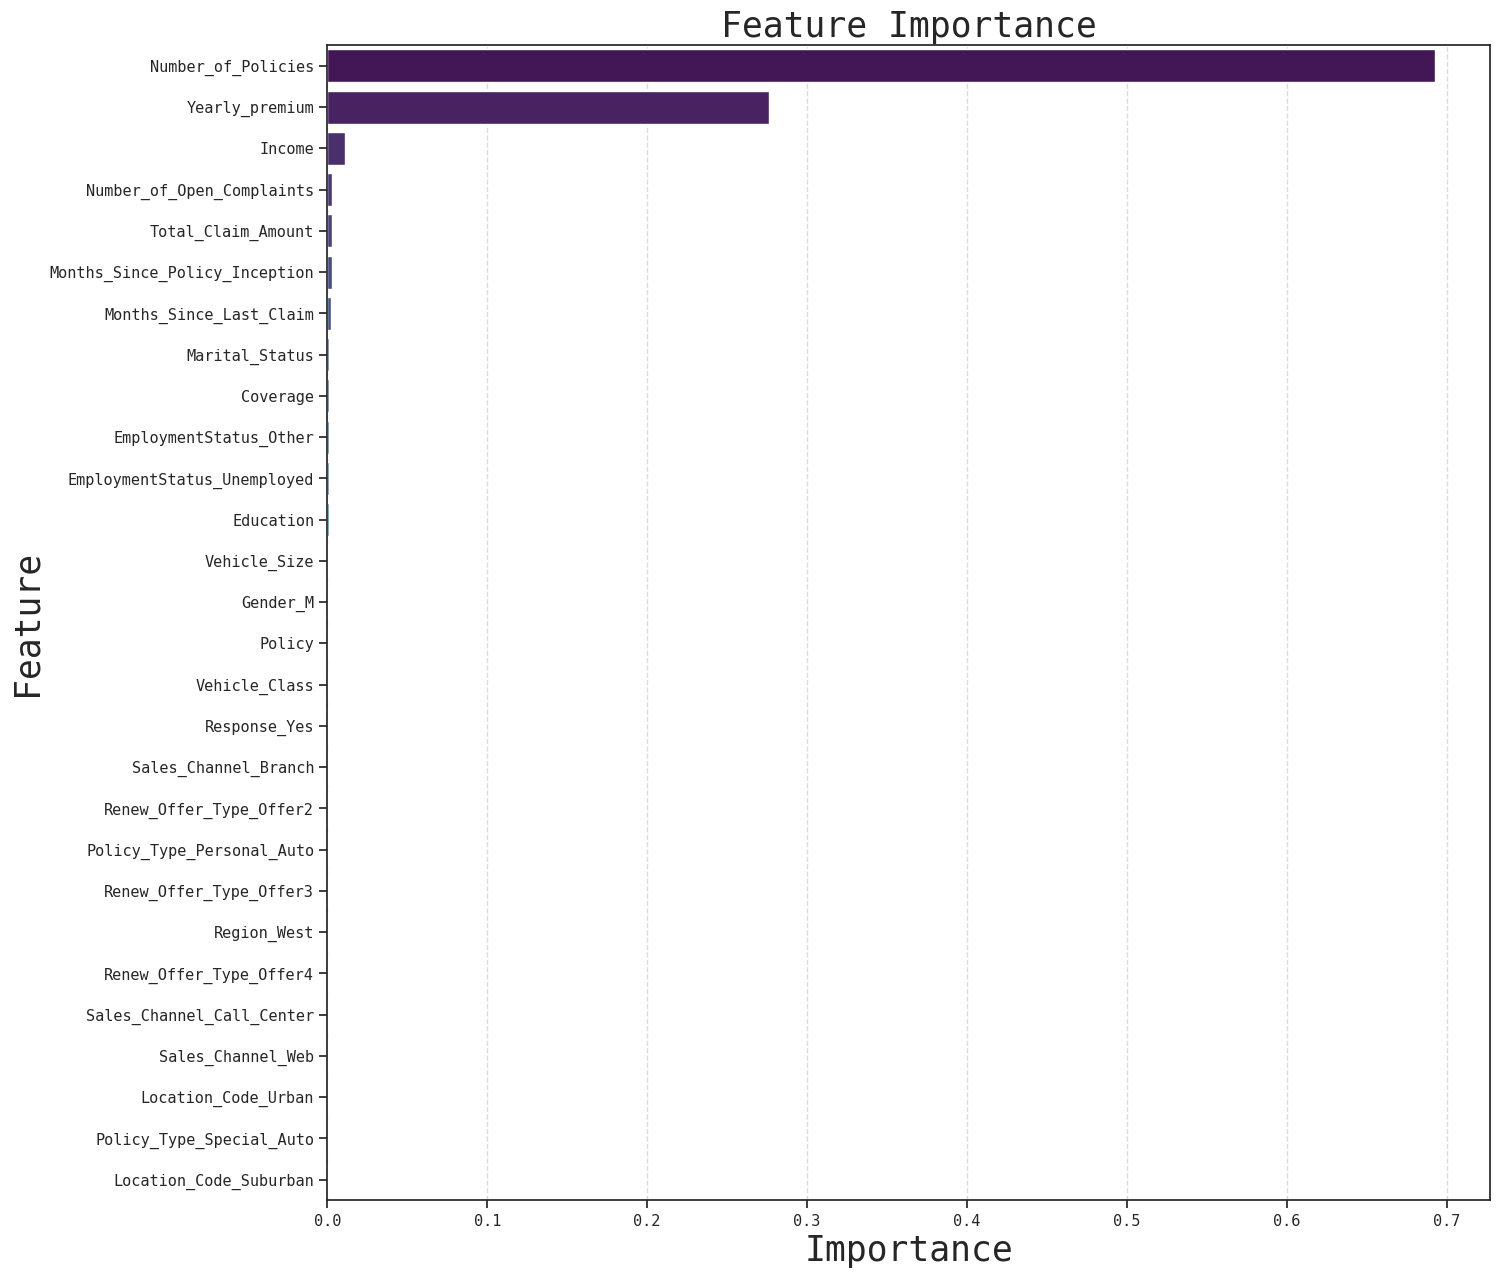

In [75]:
get_feature_importance_with_plot(model=rf, feature_names=X_train.columns, get_plot=True,
    return_df=False)

In [76]:
# There is slight improvement in performance but not significant

In [77]:
%%time
selector = RFE(estimator=rf,n_features_to_select=None,)
X_new = selector.fit_transform(X_train, y_train_transformed)
selected_features = X_train.columns[selector.get_support()]
df_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
})
df_importance.sort_values(by='Ranking', ascending=True)

CPU times: total: 55.8 s
Wall time: 56.1 s


,Feature,Ranking
0,Coverage,1
14,EmploymentStatus_Unemployed,1
11,Vehicle_Size,1
9,Total_Claim_Amount,1
8,Policy,1
7,Number_of_Policies,1
13,EmploymentStatus_Other,1
5,Months_Since_Policy_Inception,1
6,Number_of_Open_Complaints,1
1,Education,1


In [78]:
# As per RFE there are 14 features that ranking 1 

In [79]:
X_signi_columns_rfe = df_importance[df_importance['Ranking']==1]['Feature'].values.tolist()


print(X_signi_columns_rfe)
print()
X_train_signi_rfe = X_train[X_signi_columns_rfe] 
X_test_signi_rfe = X_test[X_signi_columns_rfe]


rf_rfe = train_regression_model(X_train_signi_rfe, X_test_signi_rfe,y_train_transformed, y_test_transformed, model=RandomForestRegressor())['model']

['Coverage', 'Education', 'Income', 'Marital_Status', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Policy', 'Total_Claim_Amount', 'Vehicle_Size', 'EmploymentStatus_Other', 'EmploymentStatus_Unemployed', 'Yearly_premium']

Training performance: 
Mean Squared Error  3.0959569886058016e-11
Root Mean Squared Error  5.564132446847218e-06
Mean Absolute Error  3.0511733702607183e-06
Mean Absolute Percentage Error  0.03779309544193585
R2 score  0.9974505843235
Adjusted R2 score  0.9974456896691567
None

Testing performance: 
Mean Squared Error  2.0832405936375343e-10
Root Mean Squared Error  1.4433435466435335e-05
Mean Absolute Error  7.938606813681107e-06
Mean Absolute Percentage Error  0.09991071361246864
R2 score  0.9828550843753905
Adjusted R2 score  0.9827226181398803
None


In [80]:
# we slighly improve the performance of model.

In [81]:
X_signi_columns_feat_imp = get_feature_importance_with_plot(model=rf, feature_names=X_train.columns,
                                                   get_plot=False, return_df=True)['Feature'].values.tolist()
X_signi_columns_new = X_signi_columns_feat_imp[:-24]
print(X_signi_columns_new)
print()
X_train_signi_imp = X_train[X_signi_columns_new] 
X_test_signi_imp = X_test[X_signi_columns_new]


rf_feat_imp = train_regression_model(X_train_signi_imp, X_test_signi_imp,y_train_transformed, y_test_transformed, model=RandomForestRegressor())['model']

['Number_of_Policies', 'Yearly_premium', 'Income', 'Number_of_Open_Complaints']

Training performance: 
Mean Squared Error  8.283570742669316e-11
Root Mean Squared Error  9.101412386365819e-06
Mean Absolute Error  4.5101023926330364e-06
Mean Absolute Percentage Error  0.05146112546853579
R2 score  0.9931787601744854
Adjusted R2 score  0.993175023532565
None

Testing performance: 
Mean Squared Error  2.7130408891773695e-10
Root Mean Squared Error  1.6471311086787747e-05
Mean Absolute Error  9.196002579006846e-06
Mean Absolute Percentage Error  0.10899872022964227
R2 score  0.9776718746393847
Adjusted R2 score  0.9776228557033569
None


In [82]:
%%time
gbr = train_regression_model(X_train, X_test,y_train_transformed, y_test_transformed, model=GradientBoostingRegressor())['model']

Training performance: 
Mean Squared Error  2.1271034282456932e-10
Root Mean Squared Error  1.4584592651993038e-05
Mean Absolute Error  8.935514035430744e-06
Mean Absolute Percentage Error  0.1138054884821755
R2 score  0.9824840240175666
Adjusted R2 score  0.9824166363660816
None

Testing performance: 
Mean Squared Error  2.29925038333006e-10
Root Mean Squared Error  1.5163279273725917e-05
Mean Absolute Error  9.390000602666024e-06
Mean Absolute Percentage Error  0.12217623794724408
R2 score  0.981077339822179
Adjusted R2 score  0.9807826599083976
None
CPU times: total: 1.14 s
Wall time: 1.15 s


In [83]:
get_feature_importance_with_plot(model=gbr, feature_names=X_train.columns, get_plot=False,
    return_df=True)

,Feature,Importance
7,Number_of_Policies,0.7059777
27,Yearly_premium,0.2764823
2,Income,0.0083464
14,EmploymentStatus_Unemployed,0.0023561
0,Coverage,0.0023001
6,Number_of_Open_Complaints,0.0020412
3,Marital_Status,0.0012136
15,Gender_M,0.0002707
5,Months_Since_Policy_Inception,0.0002534
13,EmploymentStatus_Other,0.0002049


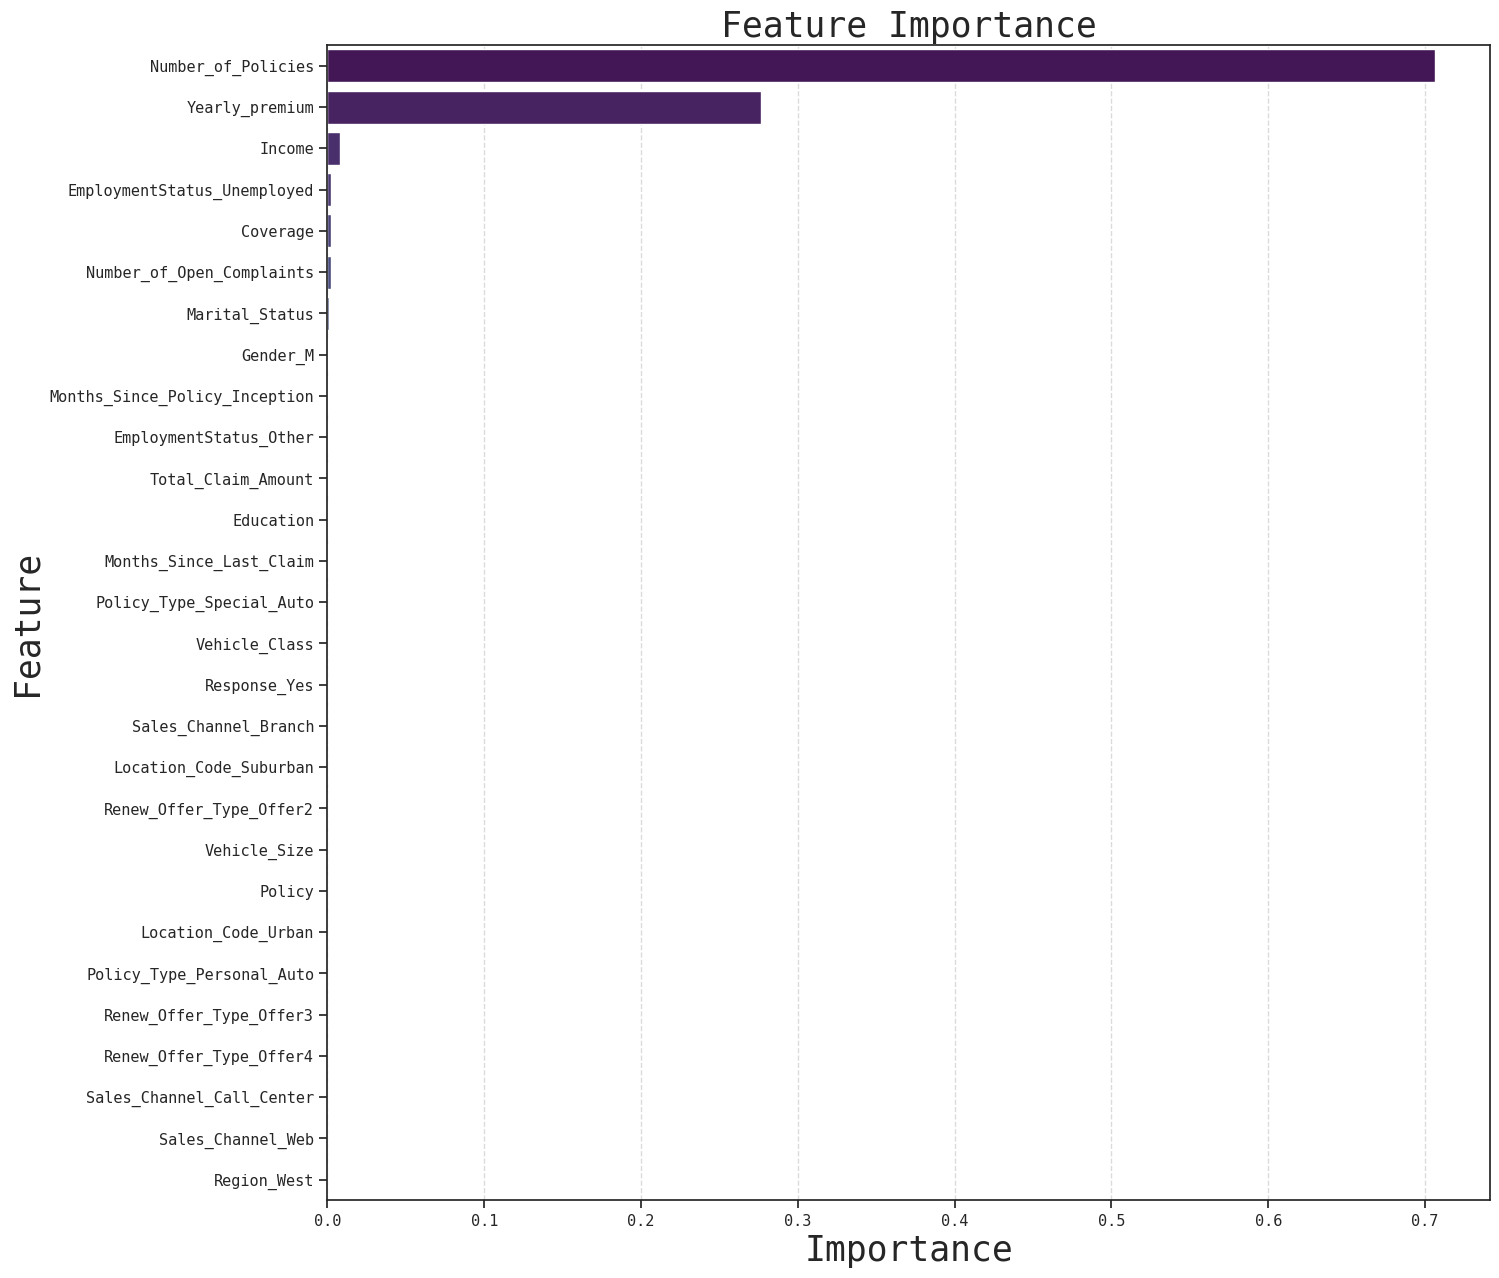

In [84]:
get_feature_importance_with_plot(model=gbr, feature_names=X_train.columns, get_plot=True,
    return_df=False)

In [85]:
%%time
selector = RFE(estimator=gbr,n_features_to_select=None,)
X_new = selector.fit_transform(X_train, y_train_transformed)
selected_features = X_train.columns[selector.get_support()]
df_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
})
df_importance.sort_values(by='Ranking', ascending=True)

CPU times: total: 15.1 s
Wall time: 15.2 s


,Feature,Ranking
0,Coverage,1
19,Policy_Type_Special_Auto,1
15,Gender_M,1
14,EmploymentStatus_Unemployed,1
9,Total_Claim_Amount,1
7,Number_of_Policies,1
13,EmploymentStatus_Other,1
5,Months_Since_Policy_Inception,1
1,Education,1
6,Number_of_Open_Complaints,1


In [86]:
X_signi_columns_rfe = df_importance[df_importance['Ranking']==1]['Feature'].values.tolist()


print(X_signi_columns_rfe)
print()
X_train_signi_rfe = X_train[X_signi_columns_rfe] 
X_test_signi_rfe = X_test[X_signi_columns_rfe]


gbr_rfe = train_regression_model(X_train_signi_rfe, X_test_signi_rfe,y_train_transformed, y_test_transformed, model=GradientBoostingRegressor())['model']

['Coverage', 'Education', 'Income', 'Marital_Status', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Total_Claim_Amount', 'EmploymentStatus_Other', 'EmploymentStatus_Unemployed', 'Gender_M', 'Policy_Type_Special_Auto', 'Yearly_premium']

Training performance: 
Mean Squared Error  2.1326194565853154e-10
Root Mean Squared Error  1.4603490872340473e-05
Mean Absolute Error  8.938998691466295e-06
Mean Absolute Percentage Error  0.11382821936029483
R2 score  0.9824386013932447
Adjusted R2 score  0.9824048850492383
None

Testing performance: 
Mean Squared Error  2.3016222771210628e-10
Root Mean Squared Error  1.5171098434592872e-05
Mean Absolute Error  9.400720349120693e-06
Mean Absolute Percentage Error  0.12242501775911364
R2 score  0.9810578193121422
Adjusted R2 score  0.9809114669227217
None


In [87]:
X_signi_columns_feat_imp = get_feature_importance_with_plot(model=rf, feature_names=X_train.columns,
                                                   get_plot=False, return_df=True)['Feature'].values.tolist()
X_signi_columns_new = X_signi_columns_feat_imp[:-14]
print(X_signi_columns_new)
print()
X_train_signi_imp = X_train[X_signi_columns_new] 
X_test_signi_imp = X_test[X_signi_columns_new]


gbr_feat_imp = train_regression_model(X_train_signi_imp, X_test_signi_imp,y_train_transformed, y_test_transformed, model=GradientBoostingRegressor())['model']

['Number_of_Policies', 'Yearly_premium', 'Income', 'Number_of_Open_Complaints', 'Total_Claim_Amount', 'Months_Since_Policy_Inception', 'Months_Since_Last_Claim', 'Marital_Status', 'Coverage', 'EmploymentStatus_Other', 'EmploymentStatus_Unemployed', 'Education', 'Vehicle_Size', 'Gender_M']

Training performance: 
Mean Squared Error  2.137191389278778e-10
Root Mean Squared Error  1.461913605271795e-05
Mean Absolute Error  8.966074399799605e-06
Mean Absolute Percentage Error  0.11406480999050263
R2 score  0.9824009530766707
Adjusted R2 score  0.9823671644512009
None

Testing performance: 
Mean Squared Error  2.3181264860154924e-10
Root Mean Squared Error  1.5225394858641573e-05
Mean Absolute Error  9.436286565012343e-06
Mean Absolute Percentage Error  0.1226971911819664
R2 score  0.9809219908966389
Adjusted R2 score  0.9807745890602995
None


In [88]:
rfe_features = X_signi_columns_rfe
feature_importance_features = X_signi_columns_new
combined_features = list(set(rfe_features).union(set(feature_importance_features)))


X_train_signi_imp_comb = X_train[combined_features] 
X_test_signi_imp_comb = X_test[combined_features]


gbr_feat_imp_comb = train_regression_model(X_train_signi_imp_comb, X_test_signi_imp_comb,y_train_transformed, y_test_transformed, model=GradientBoostingRegressor())['model']

Training performance: 
Mean Squared Error  2.1305935822364373e-10
Root Mean Squared Error  1.4596552956901973e-05
Mean Absolute Error  8.943142130673105e-06
Mean Absolute Percentage Error  0.11381217096976438
R2 score  0.982455283782059
Adjusted R2 score  0.9824191884942701
None

Testing performance: 
Mean Squared Error  2.3021732173913257e-10
Root Mean Squared Error  1.5172914081979525e-05
Mean Absolute Error  9.404572785469773e-06
Mean Absolute Percentage Error  0.12225451841975464
R2 score  0.9810532851145671
Adjusted R2 score  0.9808963548421864
None


In [89]:
common_features = list(set(rfe_features).intersection(set(feature_importance_features)))


X_train_signi_imp_com = X_train[common_features] 
X_test_signi_imp_com = X_test[common_features]


gbr_feat_imp_com = train_regression_model(X_train_signi_imp_com, X_test_signi_imp_com,y_train_transformed, y_test_transformed, model=GradientBoostingRegressor())['model']

Training performance: 
Mean Squared Error  2.1375288280694e-10
Root Mean Squared Error  1.4620290106798155e-05
Mean Absolute Error  8.96657495607462e-06
Mean Absolute Percentage Error  0.11407135459629336
R2 score  0.9823981743825679
Adjusted R2 score  0.9823667985793283
None

Testing performance: 
Mean Squared Error  2.3157652014415238e-10
Root Mean Squared Error  1.5217638454903322e-05
Mean Absolute Error  9.432972222477079e-06
Mean Absolute Percentage Error  0.12267736417782175
R2 score  0.9809414240936062
Adjusted R2 score  0.980804765799738
None


In [90]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['auto', 'log2', 0.8]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
CPU times: total: 5.94 s
Wall time: 1min 32s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 4,
  'max_features': 0.8,
  'n_estimators': 200,
  'subsample': 0.9},
 'train_rmse': 1.2477271101918835e-05,
 'test_rmse': 1.4394665298868471e-05,
 'train_r2': 0.9871800905916259,
 'test_r2': 0.9829470678121666,
 'model': GradientBoostingRegressor(max_depth=4, max_features=0.8, n_estimators=200,
                           subsample=0.9)}

In [91]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2, 3, 4],
    'subsample': [0.5, 0.6, 0.8],
    'max_features': ['auto', 'log2', 0.8]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
CPU times: total: 5.91 s
Wall time: 1min 20s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 4,
  'max_features': 0.8,
  'n_estimators': 250,
  'subsample': 0.8},
 'train_rmse': 1.2032503196745759e-05,
 'test_rmse': 1.4458266958299731e-05,
 'train_r2': 0.9880777642600267,
 'test_r2': 0.9827960409060554,
 'model': GradientBoostingRegressor(max_depth=4, max_features=0.8, n_estimators=250,
                           subsample=0.8)}

In [92]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2, 3],
    'subsample': [0.3, 0.4, 0.5],
    'max_features': ['auto', 'log2', 0.8]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
CPU times: total: 3.41 s
Wall time: 39.8 s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.8,
  'n_estimators': 250,
  'subsample': 0.5},
 'train_rmse': 1.3981574904153616e-05,
 'test_rmse': 1.5193381120324544e-05,
 'train_r2': 0.9839025190102753,
 'test_r2': 0.9810021354564227,
 'model': GradientBoostingRegressor(max_features=0.8, n_estimators=250, subsample=0.5)}

In [93]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,125, 150,175],
    'max_depth': [2, 3],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 0.9],
    'max_features': ['auto', 'log2', 0.8]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
CPU times: total: 5.36 s
Wall time: 1min 8s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.8,
  'n_estimators': 175,
  'subsample': 0.5},
 'train_rmse': 1.4126367429071996e-05,
 'test_rmse': 1.4944116880319289e-05,
 'train_r2': 0.9835673831283651,
 'test_r2': 0.9816203839905453,
 'model': GradientBoostingRegressor(max_features=0.8, n_estimators=175, subsample=0.5)}

In [94]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,125, 150,175],
    'max_depth': [2, 3],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 0.9],
    'max_features': ['auto', 'log2']
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
CPU times: total: 2.39 s
Wall time: 24.8 s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 'log2',
  'n_estimators': 175,
  'subsample': 0.9},
 'train_rmse': 1.62882880171595e-05,
 'test_rmse': 1.668983349681928e-05,
 'train_r2': 0.9781527582827944,
 'test_r2': 0.9770754969110951,
 'model': GradientBoostingRegressor(max_features='log2', n_estimators=175, subsample=0.9)}

In [95]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,125, 150,175],
    'max_depth': [2, 3],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 0.9],
    'max_features': [0.5, 0.7]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
CPU times: total: 6.31 s
Wall time: 1min 14s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.7,
  'n_estimators': 175,
  'subsample': 0.8},
 'train_rmse': 1.4436659635088046e-05,
 'test_rmse': 1.522303652342371e-05,
 'train_r2': 0.9828375546061712,
 'test_r2': 0.9809279006095405,
 'model': GradientBoostingRegressor(max_features=0.7, n_estimators=175, subsample=0.8)}

In [96]:
%%time
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,125, 150,175],
    'max_depth': [2, 3],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
CPU times: total: 9.09 s
Wall time: 1min 48s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.7,
  'n_estimators': 175,
  'subsample': 0.9},
 'train_rmse': 1.417714231837698e-05,
 'test_rmse': 1.4911526751070745e-05,
 'train_r2': 0.9834490421891209,
 'test_r2': 0.9817004611102534,
 'model': GradientBoostingRegressor(max_features=0.7, n_estimators=175, subsample=0.9)}

In [97]:
%%time
param_grid = {
    'learning_rate': [0.01,0.025, 0.0375, 0.05, 0.075, 0.0875, 0.1],
    'n_estimators': [100,125, 150, 175, 200, 225, 250, 275, 300],
    'max_depth': [3],
    'subsample': [0.9],
    'max_features': [0.7]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 63 candidates, totalling 315 fits
CPU times: total: 2.86 s
Wall time: 42.1 s


{'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.7,
  'n_estimators': 250,
  'subsample': 0.9},
 'train_rmse': 1.3863797157584974e-05,
 'test_rmse': 1.4848886977049907e-05,
 'train_r2': 0.9841725800898365,
 'test_r2': 0.981853882202175,
 'model': GradientBoostingRegressor(max_features=0.7, n_estimators=250, subsample=0.9)}

In [98]:
%%time
param_grid = {
    'learning_rate': [0.01,0.025, 0.0375, 0.05, 0.075, 0.0875],
    'n_estimators': [100,125, 150, 175, 200, 225, 250, 275, 300],
    'max_depth': [3],
    'subsample': [0.9],
    'max_features': [0.7]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: total: 3.14 s
Wall time: 37.1 s


{'best_params': {'learning_rate': 0.0875,
  'max_depth': 3,
  'max_features': 0.7,
  'n_estimators': 300,
  'subsample': 0.9},
 'train_rmse': 1.3714883902880025e-05,
 'test_rmse': 1.4807831962194031e-05,
 'train_r2': 0.984510763720016,
 'test_r2': 0.9819540862435366,
 'model': GradientBoostingRegressor(learning_rate=0.0875, max_features=0.7,
                           n_estimators=300, subsample=0.9)}

In [99]:
%%time
param_grid = {
    'learning_rate': [0.01,0.025, 0.0375, 0.05, 0.075, 0.0875],
    'n_estimators': [100,125, 150, 175, 200, 225, 250, 275, 300],
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: total: 3.75 s
Wall time: 49.9 s


{'best_params': {'learning_rate': 0.0875, 'n_estimators': 300},
 'train_rmse': 1.3532011658507273e-05,
 'test_rmse': 1.4682209290910841e-05,
 'train_r2': 0.9849210722592956,
 'test_r2': 0.9822589735382846,
 'model': GradientBoostingRegressor(learning_rate=0.0875, n_estimators=300)}

In [100]:
%%time
param_grid = {
    'learning_rate': [0.03, 0.05, 0.1],
    'n_estimators': [50,75,100,125]
}


tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_grid,search_method='grid', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 1.22 s
Wall time: 5.92 s


{'best_params': {'learning_rate': 0.1, 'n_estimators': 125},
 'train_rmse': 1.4388326558203742e-05,
 'test_rmse': 1.5058247488345595e-05,
 'train_r2': 0.982952279927995,
 'test_r2': 0.9813385758497843,
 'model': GradientBoostingRegressor(n_estimators=125)}

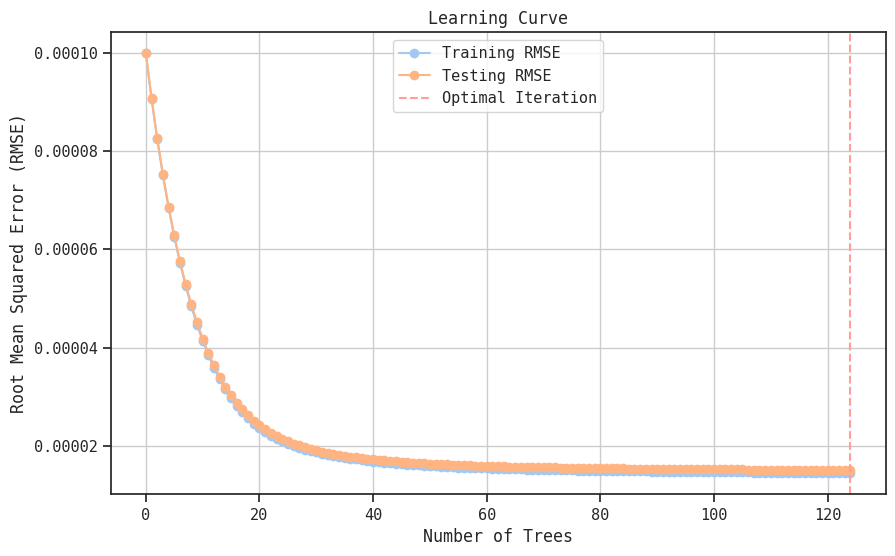

Optimal Iteration: 124


In [101]:
plot_learning_curve(GradientBoostingRegressor(learning_rate=0.1, n_estimators=125), 
                    X_train_signi_imp_com, y_train_transformed, X_test_signi_imp_com, y_test_transformed)

In [102]:
%%time
param_distributions = {
    'n_estimators': randint(100, 300),               # Number of boosting stages
    'learning_rate': uniform(0.01, 0.3),            # Continuous range for learning rate (0.01 to 0.31)
    'max_depth': randint(3, 10),                    # Integer range for max depth
    'min_samples_split': randint(2, 20),            # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),             # Minimum samples required to be a leaf node
    'subsample': uniform(0.6, 0.4),                 # Continuous range for subsample (0.6 to 1.0)
    'max_features': uniform(0.5, 0.5),              # Continuous range for max features (0.5 to 1.0)
}



tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_distributions,n_iter=500,search_method='random', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
CPU times: total: 12.6 s
Wall time: 8min 8s


{'best_params': {'learning_rate': 0.04970970707970537,
  'max_depth': 5,
  'max_features': 0.7824513507476938,
  'min_samples_leaf': 4,
  'min_samples_split': 17,
  'n_estimators': 244,
  'subsample': 0.7164977514152925},
 'train_rmse': 1.216149357895664e-05,
 'test_rmse': 1.4154907010460508e-05,
 'train_r2': 0.9878207775399435,
 'test_r2': 0.9835104059564657,
 'model': GradientBoostingRegressor(learning_rate=0.04970970707970537, max_depth=5,
                           max_features=0.7824513507476938, min_samples_leaf=4,
                           min_samples_split=17, n_estimators=244,
                           subsample=0.7164977514152925)}

In [103]:
%%time
param_distributions = {
    'n_estimators': randint(100, 300),               # Number of boosting stages
    'learning_rate': uniform(0.01, 0.3),            # Continuous range for learning rate (0.01 to 0.31)
    'max_depth': randint(2,3),                    # Integer range for max depth
    'min_samples_split': randint(2, 20),            # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),             # Minimum samples required to be a leaf node
    'subsample': uniform(0.6, 0.4),                 # Continuous range for subsample (0.6 to 1.0)
    'max_features': uniform(0.5, 0.5),              # Continuous range for max features (0.5 to 1.0)
}



tune_regression_model(X_train_signi_imp_com, X_test_signi_imp_com, y_train_transformed, y_test_transformed, model=GradientBoostingRegressor(),
                      param_space=param_distributions,n_iter=500,search_method='random', cv=5, shuffle=True, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
CPU times: total: 11.6 s
Wall time: 3min 38s


{'best_params': {'learning_rate': 0.20908368224549298,
  'max_depth': 2,
  'max_features': 0.8608786819491893,
  'min_samples_leaf': 5,
  'min_samples_split': 18,
  'n_estimators': 292,
  'subsample': 0.9239530982314135},
 'train_rmse': 1.4637354908464797e-05,
 'test_rmse': 1.534953759956021e-05,
 'train_r2': 0.9823570607031772,
 'test_r2': 0.9806096112287983,
 'model': GradientBoostingRegressor(learning_rate=0.20908368224549298, max_depth=2,
                           max_features=0.8608786819491893, min_samples_leaf=5,
                           min_samples_split=18, n_estimators=292,
                           subsample=0.9239530982314135)}

In [104]:
gbr_feat_imp_com_tuned = train_regression_model(X_train_signi_imp_com, X_test_signi_imp_com,y_train_transformed,
                                                y_test_transformed, model=GradientBoostingRegressor(learning_rate=0.20852530267814168, max_depth=2,
                           max_features=0.9566469625715315, min_samples_leaf=4,
                           min_samples_split=7, n_estimators=288,
                           subsample=0.8877518431912326))['model']

Training performance: 
Mean Squared Error  2.1390330727578882e-10
Root Mean Squared Error  1.4625433575651315e-05
Mean Absolute Error  9.383283787623482e-06
Mean Absolute Percentage Error  0.11253748902152502
R2 score  0.9823857874372576
Adjusted R2 score  0.9823543895539015
None

Testing performance: 
Mean Squared Error  2.375283778372684e-10
Root Mean Squared Error  1.541195567853958e-05
Mean Absolute Error  9.918344980497923e-06
Mean Absolute Percentage Error  0.1220604487022849
R2 score  0.9804515906184434
Adjusted R2 score  0.9803114200051173
None


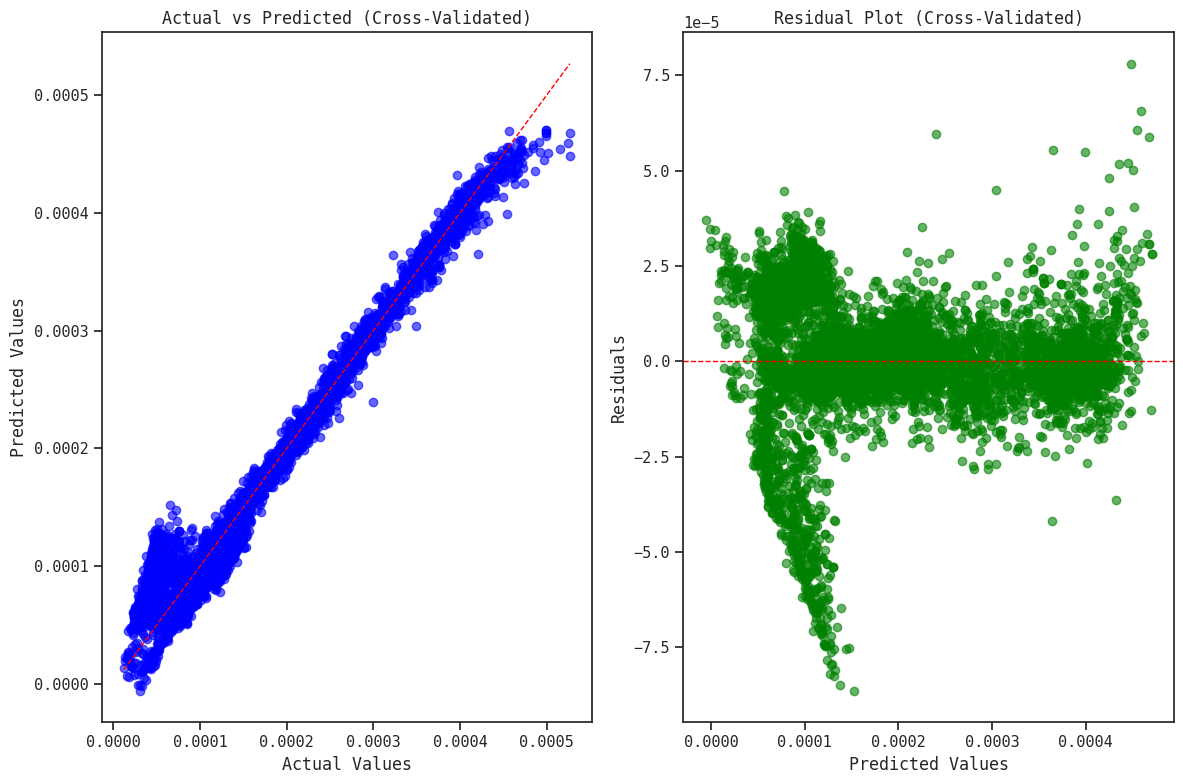

In [105]:
plot_residual_plot(gbr_feat_imp_com_tuned,X_train_signi_imp_com,y_train_transformed)

In [106]:
kf = KFold(n_splits=10,shuffle=True)
cross_val_score(estimator=gbr_feat_imp_com_tuned,cv=kf, X=X_train_signi_imp_com, y=y_train_transformed,scoring='r2')

array([0.9757404, 0.9810449, 0.9787722, 0.9845794, 0.9798304, 0.9782945,
       0.9819104, 0.9796502, 0.9788032, 0.9788769])

In [107]:
gbm = train_regression_model(X_train, X_test,y_train_transformed,
                                                y_test_transformed, model=LGBMRegressor(force_col_wise=True))['model']

[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 28
[LightGBM] [Info] Start training from score 0.000191
Training performance: 
Mean Squared Error  1.2160185642879995e-10
Root Mean Squared Error  1.1027323176038686e-05
Mean Absolute Error  6.497619518157905e-06
Mean Absolute Percentage Error  0.08431850495762312
R2 score  0.9899864991596443
Adjusted R2 score  0.9899479751113439
None

Testing performance: 
Mean Squared Error  2.0171636704121353e-10
Root Mean Squared Error  1.4202688725773495e-05
Mean Absolute Error  8.014424986489818e-06
Mean Absolute Percentage Error  0.10630299947808595
R2 score  0.9833988925542888
Adjusted R2 score  0.9831403658532433
None


[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 28
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Warning] Detected that num_threads changed during training (from 6 to 12), it may cause unexpected errors.


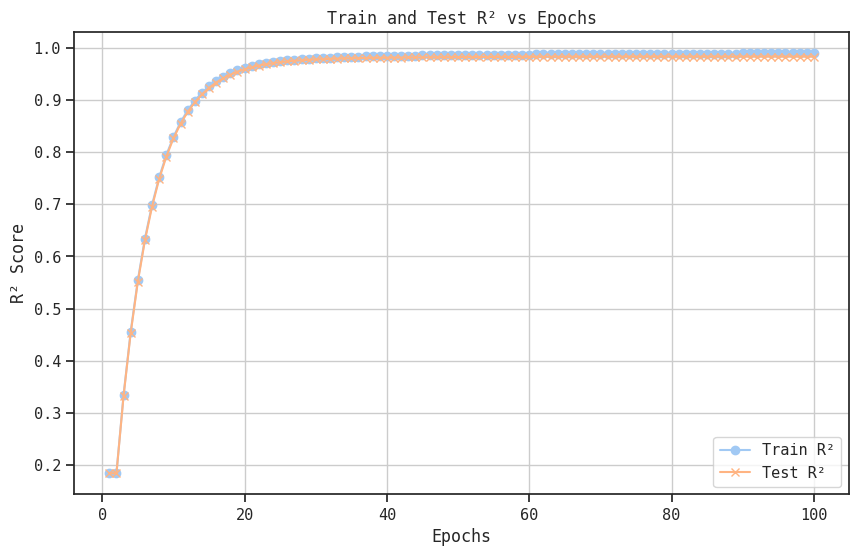

In [108]:
plot_model_r2(gbm, X_train,X_test,y_train_transformed, y_test_transformed)

[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 28
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Warning] Detected that num_threads changed during training (from 6 to 12), it may cause unexpected errors.


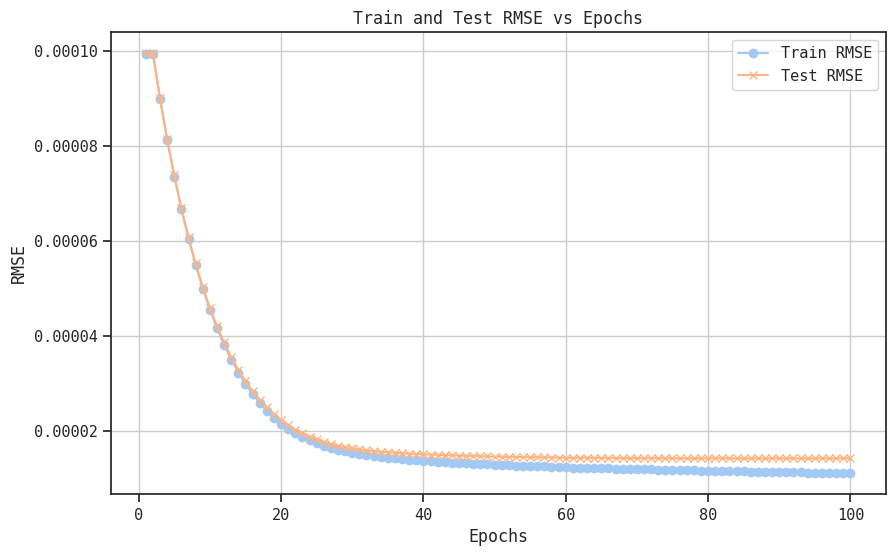

In [109]:
plot_model_rmse(gbm, X_train,X_test,y_train_transformed, y_test_transformed)

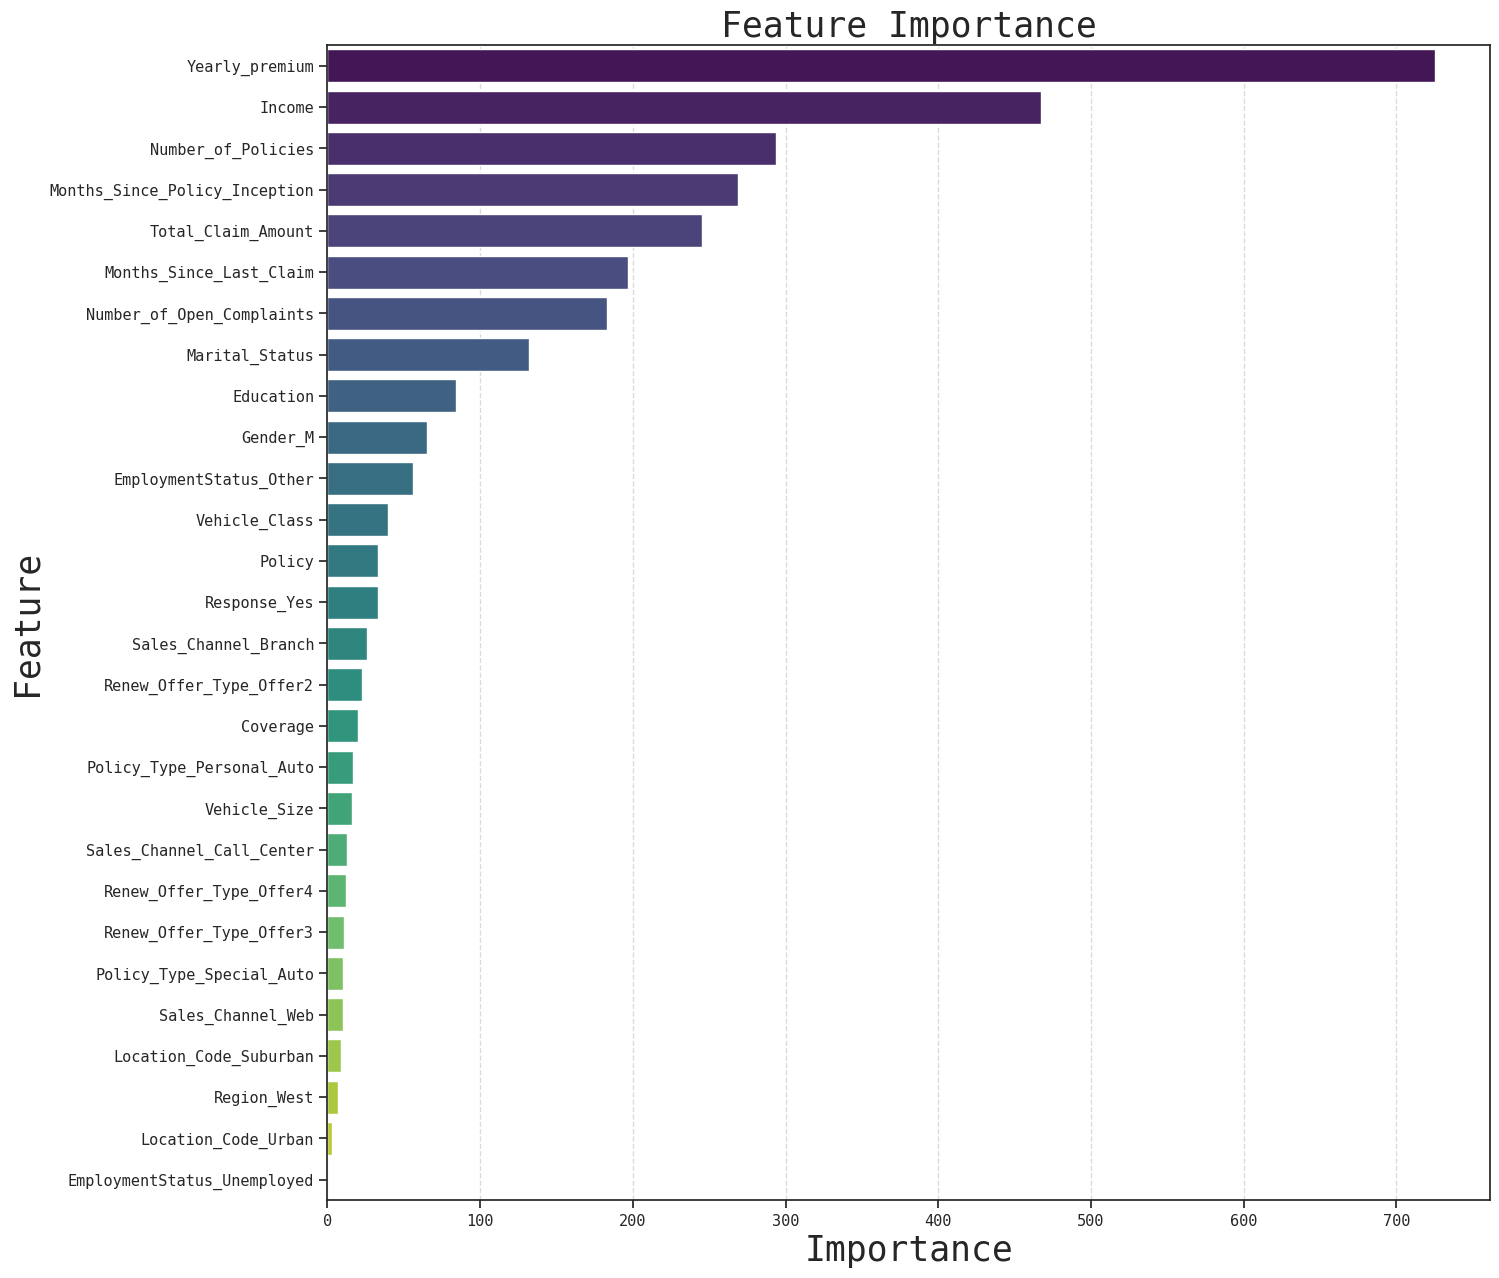

In [110]:
get_feature_importance_with_plot(model=gbm, feature_names=X_train.columns, get_plot=True,
    return_df=False)

In [111]:
%%time
selector = RFE(estimator=gbm,n_features_to_select=None,)
X_new = selector.fit_transform(X_train, y_train_transformed)
selected_features = X_train.columns[selector.get_support()]
df_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
})
df_importance.sort_values(by='Ranking', ascending=True)

[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 28
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 27
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 26
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 25
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 24
[LightGBM] [Info] Start training from score 0.000191
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 7307, number of use

,Feature,Ranking
13,EmploymentStatus_Other,1
15,Gender_M,1
12,Response_Yes,1
10,Vehicle_Class,1
9,Total_Claim_Amount,1
8,Policy,1
7,Number_of_Policies,1
27,Yearly_premium,1
5,Months_Since_Policy_Inception,1
4,Months_Since_Last_Claim,1


In [112]:
X_signi_columns_rfe = df_importance[df_importance['Ranking']==1]['Feature'].values.tolist()


print(X_signi_columns_rfe)
print()
X_train_signi_rfe = X_train[X_signi_columns_rfe] 
X_test_signi_rfe = X_test[X_signi_columns_rfe]


rf_rfe = train_regression_model(X_train_signi_rfe, X_test_signi_rfe,y_train_transformed, y_test_transformed, model=LGBMRegressor())['model']

['Education', 'Income', 'Marital_Status', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Policy', 'Total_Claim_Amount', 'Vehicle_Class', 'Response_Yes', 'EmploymentStatus_Other', 'Gender_M', 'Yearly_premium']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 14
[LightGBM] [Info] Start training from score 0.000191
Training performance: 
Mean Squared Error  1.1951977735125882e-10
Root Mean Squared Error  1.093251011210412e-05
Mean Absolute Error  6.417111952607184e-06
Mean Absolute Percentage Error  0.08327048402145554
R2 score  0.990157951316749
Adjusted R2 score  0.9901390554470884
None

Testing performance: 
Mean Squared Error 

In [113]:
X_signi_columns_feat_imp = get_feature_importance_with_plot(model=gbr, feature_names=X_train.columns,
                                                   get_plot=False, return_df=True)['Feature'].values.tolist()
X_signi_columns_new = X_signi_columns_feat_imp[:-16]
print(X_signi_columns_new)
print()
X_train_signi_imp = X_train[X_signi_columns_new] 
X_test_signi_imp = X_test[X_signi_columns_new]


gbm_feat_imp = train_regression_model(X_train_signi_imp, X_test_signi_imp,y_train_transformed, y_test_transformed, model=LGBMRegressor())['model']

['Number_of_Policies', 'Yearly_premium', 'Income', 'EmploymentStatus_Unemployed', 'Coverage', 'Number_of_Open_Complaints', 'Marital_Status', 'Gender_M', 'Months_Since_Policy_Inception', 'EmploymentStatus_Other', 'Total_Claim_Amount', 'Education']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 12
[LightGBM] [Info] Start training from score 0.000191
Training performance: 
Mean Squared Error  1.3253334111182486e-10
Root Mean Squared Error  1.1512312587478889e-05
Mean Absolute Error  6.740747484903229e-06
Mean Absolute Percentage Error  0.08796204475753032
R2 score  0.9890863284363142
Adjusted R2 score  0.9890683733967249
None

Testing performance: 
Mean Squared Error  2.036034310206779e-10
Ro

In [114]:
rfe_features = X_signi_columns_rfe
feature_importance_features = X_signi_columns_new
common_features = list(set(rfe_features).intersection(set(feature_importance_features)))
print(common_features)

X_train_signi_imp_comb = X_train[common_features] 
X_test_signi_imp_comb = X_test[common_features]


gbr_feat_imp_comb = train_regression_model(X_train_signi_imp_com, X_test_signi_imp_com,y_train_transformed, y_test_transformed, model=LGBMRegressor())['model']

['EmploymentStatus_Other', 'Yearly_premium', 'Total_Claim_Amount', 'Income', 'Gender_M', 'Number_of_Open_Complaints', 'Education', 'Number_of_Policies', 'Marital_Status', 'Months_Since_Policy_Inception']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 13
[LightGBM] [Info] Start training from score 0.000191
Training performance: 
Mean Squared Error  1.2657835832060178e-10
Root Mean Squared Error  1.125070479217199e-05
Mean Absolute Error  6.5959981559348036e-06
Mean Absolute Percentage Error  0.08532460717151441
R2 score  0.9895767010912673
Adjusted R2 score  0.989558121235815
None

Testing performance: 
Mean Squared Error  2.009719927620337e-10
Root Mean Squared Error  1.4176459105222068e-05

In [115]:
%%time
# final model
gbm_feat_imp_com_tuned = train_regression_model(X_train_signi_imp_com,
                                           X_test_signi_imp_com,y_train_transformed, 
                                           y_test_transformed, 
                            model=LGBMRegressor(bagging_fraction=0.8951391765968398, bagging_freq=9,
               extra_trees=False, feature_fraction=0.845673295206703,
               lambda_l1=1.1648977222288289e-08,
               learning_rate=0.23858036773838634, max_bin=144, max_depth=2,
               min_child_weight=0.44277198722095246, min_data_in_leaf=83,
               min_sum_hessian_in_leaf=6.201695725261655, n_estimators=234,
               num_leaves=236, path_smooth=0.3927731549551428,
               subsample=0.6551481783116675, verbose=-1))['model']

Training performance: 
Mean Squared Error  2.358513207179461e-10
Root Mean Squared Error  1.5357451634888717e-05
Mean Absolute Error  9.775439175283498e-06
Mean Absolute Percentage Error  0.11729301038064482
R2 score  0.9805784428990937
Adjusted R2 score  0.9805438233677195
None

Testing performance: 
Mean Squared Error  2.500582432861309e-10
Root Mean Squared Error  1.581323000800693e-05
Mean Absolute Error  1.0268669248300059e-05
Mean Absolute Percentage Error  0.1247959500925511
R2 score  0.9794203919822199
Adjusted R2 score  0.9792728272253356
None
CPU times: total: 484 ms
Wall time: 72.1 ms


In [116]:
kf = KFold(n_splits=10, shuffle=True)
cross_val_score(estimator=gbr_feat_imp_com_tuned, 
                X=X_train_signi_imp_com,y=y_train_transformed, 
                cv=kf, scoring='r2', n_jobs=-1)

array([0.9788586, 0.9778868, 0.9781682, 0.9811556, 0.9803356, 0.9798365,
       0.9809098, 0.9816803, 0.9768513, 0.9802066])

In [117]:
# cross validation score is not varying too much which is good sign.

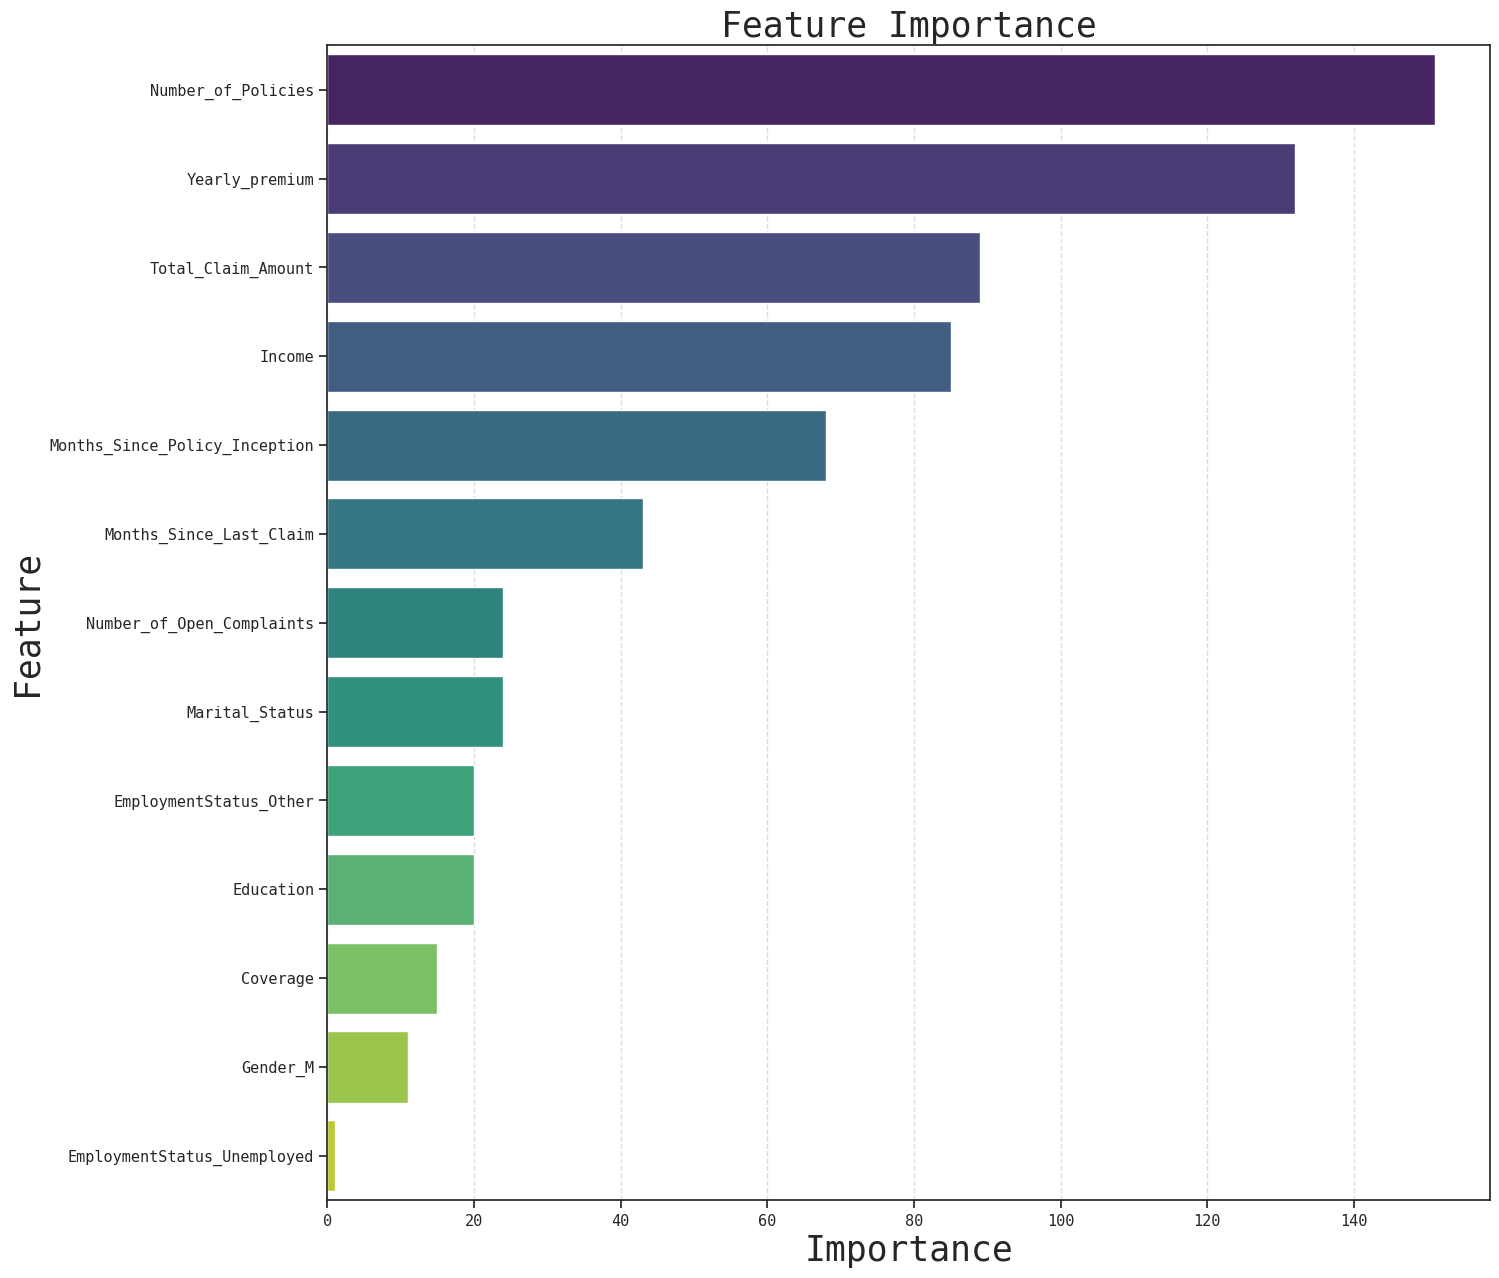

In [118]:
get_feature_importance_with_plot(gbm_feat_imp_com_tuned,X_train_signi_imp_com.columns)

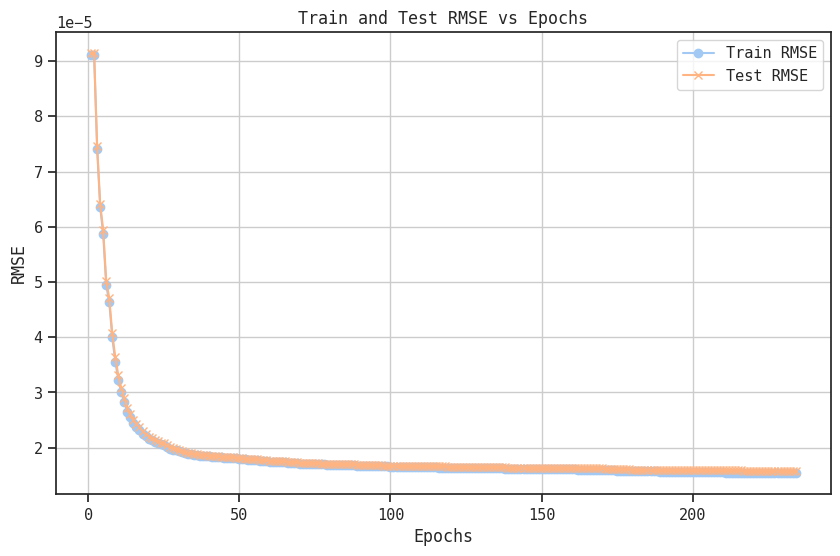

In [120]:
plot_model_rmse(gbm_feat_imp_com_tuned, X_train_signi_imp_com,
                                            X_test_signi_imp_com,y_train_transformed,
                                           y_test_transformed)

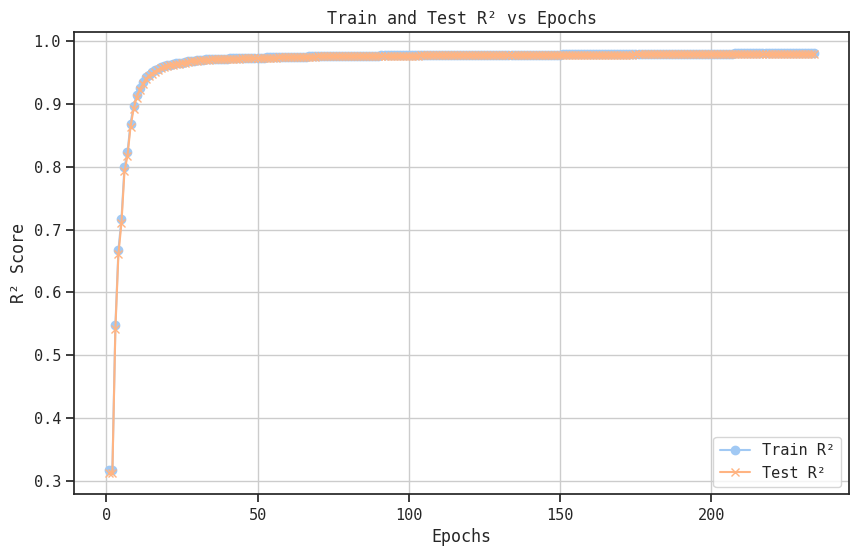

In [121]:
plot_model_r2(gbm_feat_imp_com_tuned, X_train_signi_imp_com,
                                            X_test_signi_imp_com,y_train_transformed,
                                           y_test_transformed)

# Stacking

In [122]:
%%time
base_models = [
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=50)),
    ('xg_boost', XGBRegressor()),
    ('lightGBM', LGBMRegressor(n_estimators=25,max_depth=2))
]


meta_model = LinearRegression(positive=False)

kf = KFold(n_splits=10, shuffle=True)

stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2, n_jobs=-1)


stacking_model = train_regression_model(X_train_signi_imp_com,
                                           X_test_signi_imp_com,y_train_transformed, 
                                           y_test_transformed, 
                            model=stacking)['model']

Training performance: 
Mean Squared Error  2.3282214194967602e-10
Root Mean Squared Error  1.5258510476113847e-05
Mean Absolute Error  9.674070923304426e-06
Mean Absolute Percentage Error  0.11958121167951324
R2 score  0.9808278855065709
Adjusted R2 score  0.9807937106144257
None

Testing performance: 
Mean Squared Error  2.459400023510499e-10
Root Mean Squared Error  1.5682474369532695e-05
Mean Absolute Error  1.0021254652681797e-05
Mean Absolute Percentage Error  0.12663473685341337
R2 score  0.979759320157724
Adjusted R2 score  0.9796141856635434
None
CPU times: total: 1.83 s
Wall time: 8.26 s


In [123]:
%%time
base_models = [
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=50)),
    ('lightGBM', LGBMRegressor(n_estimators=25,max_depth=2))
]


meta_model = LinearRegression(positive=False)

kf = KFold(n_splits=10, shuffle=True)

stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2, n_jobs=-1)


stacking_model = train_regression_model(X_train_signi_imp_com,
                                           X_test_signi_imp_com,y_train_transformed, 
                                           y_test_transformed, 
                            model=stacking)['model']

Training performance: 
Mean Squared Error  2.329260589895554e-10
Root Mean Squared Error  1.526191531196381e-05
Mean Absolute Error  9.731157904729874e-06
Mean Absolute Percentage Error  0.11986523975410855
R2 score  0.9808193282904499
Adjusted R2 score  0.9807851381448001
None

Testing performance: 
Mean Squared Error  2.4628447564984424e-10
Root Mean Squared Error  1.56934532735738e-05
Mean Absolute Error  1.0087496082522804e-05
Mean Absolute Percentage Error  0.12715992766252002
R2 score  0.9797309702606416
Adjusted R2 score  0.9795856324853456
None
CPU times: total: 1.5 s
Wall time: 7.61 s


In [125]:
X_train_signi_imp_com.columns

Index(['EmploymentStatus_Other', 'Yearly_premium', 'Total_Claim_Amount',
       'Income', 'EmploymentStatus_Unemployed', 'Coverage',
       'Number_of_Open_Complaints', 'Gender_M', 'Months_Since_Last_Claim',
       'Number_of_Policies', 'Education', 'Marital_Status',
       'Months_Since_Policy_Inception'],
      dtype='object')